<a href="https://colab.research.google.com/github/augustrainstorm/LISA-EMRI-Search/blob/main/EMRI_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# _LISA EMRI Data Analysis Notebook_

This notebook was developed by August Muller (current owner) with prior contributions from Quentin Baghi, Ava Stockman, and Kaia Smith.

This notebook consists of LISA Data Challenge data visualization and processing, as well as a prototype for the LISA EMRI Markov Chain Monte Carlo search. A full search is being implemented based on this prototype using the University of Washington supercomputing cluster. 

The LISA Data Challange data files and codes used in this notebook can be found on the LISA Data Challenge website:
* files: https://lisa-ldc.lal.in2p3.fr/file
* codes: https://lisa-ldc.lal.in2p3.fr/code

The objectives of the notebook are:
* to manipulate and plot LDC data sets
* to calculate the EMRI source signal-to-noise ratio
* to develop and test a template-matching likelihood for EMRIs
* to prototype an MCMC EMRI search

### 0. Install LISA Data Challenge data and packages

In [ ]:
!apt-get -q install libgsl-dev
!apt-get -q install libfftw3-dev

In [ ]:
%cd /home

Install LISA constants:

In [ ]:
!wget -q --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Mv7x_RdDh_cRZKya-YbXRvmsV3rnIh01' -O constants.zip

In [ ]:
!ls -l

In [ ]:
!unzip constants.zip; cd constants-master; python setup.py install install_headers; cd ..

In [ ]:
!ls /usr/local/include/python3.7/lisaconstants

Install LISA Data Challenges Master resources:

In [17]:
!wget -q --no-check-certificate 'https://docs.google.com/uc?export=download&id=1lx3KbAGucKiGI7mGSG-YWj5J4cTSmIlg' -O LDC-master.zip

In [ ]:
!unzip LDC-master.zip; cd LDC-master; pip install -r requirements.txt; cd ..

In [ ]:
!cp /usr/local/include/python3.7/lisaconstants/lisaconstants* /usr/include/
!cd LDC-master; python setup.py build_liborbits install; cd ..

Install LISA Data Challenge EMRI data:

In [23]:
!wget -q https://www.dropbox.com/s/vj1d4bjwoj3rfxh/LDC1-2_EMRI_v2_noiseless.hdf5?dl=0
!wget -q https://www.dropbox.com/s/1t0k2eir7qlecxc/LDC1-2_EMRI_v2.hdf5?dl=0

In [ ]:
ls  # check that everything is properly downloaded before continuing

### 1. Importing needed packages

Import necessary Python packages:

In [37]:
import numpy as np
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt 
import pandas as pd
import scipy.signal
from scipy.interpolate import InterpolatedUnivariateSpline as spline
import xarray as xr
from astropy import units as un
import copy
import time
import statistics
from optparse import OptionParser

In [ ]:
!cd ..
!pwd

Add LISA Data Challenge packages to the Python path:

In [32]:
import sys, os, re

sys.path.append("/usr/local/lib/python3.7/dist-packages/ldc-0.1-py3.7-linux-x86_64.egg")
sys.path.append("/usr/local/lib/python3.7/dist-packages/lisaconstants-1.0-py3.7.egg")
sys.path.append("/LDC-master/ldc")

In [34]:
sys.path.append("/home/MLDC-master/software/Packages/common")

In [41]:
sys.path.append("/root/.local/lib/python3.6/site-ldcpipeline")

### 2. Reading hdf5 data files

#### 2.1 Load noiseless data

In [42]:
# Specify the hdf5 file path
hdf5_path = "/home/LDC1-2_EMRI_v2_noiseless.hdf5?dl=0"
# Open the file
FD5 =  h5py.File(hdf5_path)  
# Store specified source parameters
names = np.array(FD5['H5LISA/GWSources/EMRI-0'])
# Get source parameters
params = [FD5['H5LISA/GWSources/EMRI-0'][k] for k in names]
params = [np.array(p) for p in params if p.shape]
# Get the time delay interferometry data
tdi = np.array(FD5["H5LISA/PreProcess/TDIdata"])
tdi = np.rec.fromarrays(list(tdi.T), names=["Time", "TDI X", "TDI Y", "TDI Z"])
# Sampling time
del_t = float(np.array(FD5['H5LISA/GWSources/EMRI-0']['Cadence']))
# Observation duration
Tobs = float(np.array(FD5['H5LISA/GWSources/EMRI-0']['ObservationDuration']))

Print and store the 15 EMRI waveform parameters for this signal:

In [44]:
thetaK = np.array(FD5['H5LISA/GWSources/EMRI-0']['AzimuthalAngleOfSpin'])
print('Azimuthal angle of spin (rad):', thetaK)
dist = np.array(FD5['H5LISA/GWSources/EMRI-0']['Distance'])
print('Luminosity distance (Gpc):', dist)
beta = np.array(FD5['H5LISA/GWSources/EMRI-0']['EclipticLatitude'])
print('Ecliptic latitude (rad):', beta)
lam = np.array(FD5['H5LISA/GWSources/EMRI-0']['EclipticLongitude'])
print('Ecliptic longitude (rad):', lam)
a0 = np.array(FD5['H5LISA/GWSources/EMRI-0']['InitialAlphaAngle'])
print('Initial azimuthal orbit angle (rad):', a0)
v0 = np.array(FD5['H5LISA/GWSources/EMRI-0']['InitialAzimuthalOrbitalFrequency'])
print('Initial radial orbital frequency (Hz):', v0)
phi0 = np.array(FD5['H5LISA/GWSources/EMRI-0']['InitialAzimuthalOrbitalPhase'])
print('Initial azimuthal orbital phase (rad):', phi0)
e = np.array(FD5['H5LISA/GWSources/EMRI-0']['InitialEccentricity'])
print('Initial eccentricity:', e)
gamma0 = np.array(FD5['H5LISA/GWSources/EMRI-0']['InitialTildeGamma'])
print('Initial direction of pericenter (rad):', gamma0)
bigLam = np.array(FD5['H5LISA/GWSources/EMRI-0']['LambdaAngle'])
print('Orbital inclination (rad):', bigLam)
m = np.array(FD5['H5LISA/GWSources/EMRI-0']['MassOfCompactObject'])
print('Compact object mass (solar masses):', m)
M = np.array(FD5['H5LISA/GWSources/EMRI-0']['MassOfSMBH'])
print('Supermassive black hole mass (solar masses):', M)
t_pl = np.array(FD5['H5LISA/GWSources/EMRI-0']['PlungeTime'])
print('Plunge time (s):', t_pl)
phiK = np.array(FD5['H5LISA/GWSources/EMRI-0']['PolarAngleOfSpin'])
print('Polar angle of spin (rad):', phiK)
S = np.array(FD5['H5LISA/GWSources/EMRI-0']['SMBHspin'])
print('Spin (solar masses squared):', S)

Azimuthal angle of spin (rad): 3.94669816604
Luminosity distance (Gpc): 5.235888314207546
Ecliptic latitude (rad): 0.49894448924039203
Ecliptic longitude (rad): 2.23279697592
Initial azimuthal orbit angle (rad): 1.175479035975819
Initial radial orbital frequency (Hz): 0.0007380463140752472
Initial azimuthal orbital phase (rad): 2.041531919926726
Initial eccentricity: 0.22865665220266215
Initial direction of pericenter (rad): 5.659686197804838
Orbital inclination (rad): 2.1421999999999106
Compact object mass (solar masses): 29.489999547765798
Supermassive black hole mass (solar masses): 1134944.869275098
Plunge time (s): 35880038.8057
Polar angle of spin (rad): 1.522100180545765
Spin (solar masses squared): 0.9697


In [ ]:
os.listdir("/home")

#### 2.2 Load noisy data

In [46]:
# Specify the hdf5 file path for noisy data
hdf5_path_noise = "/home/LDC1-2_EMRI_v2.hdf5?dl=0"
# Open the file
FD5_noise =  h5py.File(hdf5_path_noise)
# Get the time delay interferometry data
td_noise = np.array(FD5_noise["H5LISA/PreProcess/TDIdata"])
td_noise = np.rec.fromarrays(list(td_noise.T), names=["Time", "TDI X (noisy)", "TDI Y (noisy)", "TDI Z (noisy)"])
print(td_noise)

[(1.5000000e+01, -1.99406686e-20, -8.42435443e-21, -3.58343997e-21)
 (3.0000000e+01, -2.73159865e-21,  3.15585389e-20, -3.70119294e-21)
 (4.5000000e+01,  2.20369762e-20, -3.11280877e-20, -8.46007401e-21) ...
 (6.2914545e+07,  1.11574684e-21,  4.63215959e-22, -1.91249314e-21)
 (6.2914560e+07,  1.43653517e-21, -1.11202353e-20,  9.81482476e-22)
 (6.2914575e+07,  2.05345914e-20, -8.15947858e-21, -1.61145429e-21)]


#### 2.3 Plot the TDI data in the time domain

Plot X-channel data:

Noiseless dataframe:
               Time          TDI X          TDI Y          TDI Z
0              15.0  -4.589813e-25   7.454208e-25   1.383577e-25
1              30.0  -3.779482e-26   1.395496e-24  -3.190108e-24
2              45.0   1.232361e-24   1.523418e-24  -2.683153e-25
3              60.0  -4.025361e-26   1.428786e-25  -2.401943e-24
4              75.0   1.924103e-24   1.288886e-24  -1.756581e-24
...             ...            ...            ...            ...
4194300  62914515.0 -9.881313e-323  1.235164e-322 -2.223295e-322
4194301  62914530.0  6.422853e-323 -2.272702e-322  3.260833e-322
4194302  62914545.0  2.470328e-323  1.679823e-322 -3.112614e-322
4194303  62914560.0 -1.333977e-322 -8.399116e-323  2.025669e-322
4194304  62914575.0  1.432790e-322  2.470328e-323   0.000000e+00

[4194305 rows x 4 columns]
Noisy dataframe:
               Time  TDI X (noisy)  TDI Y (noisy)  TDI Z (noisy)
0              15.0  -1.994067e-20  -8.424354e-21  -3.583440e-21
1              30.0  -2.

<Figure size 640x480 with 0 Axes>

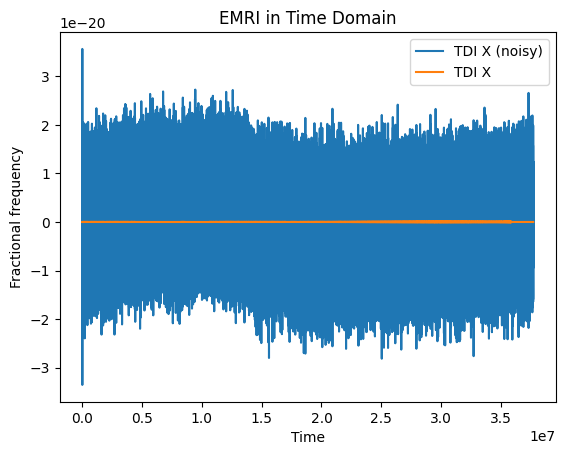

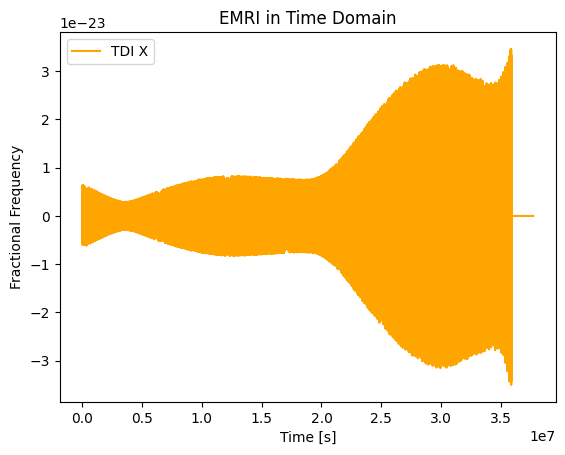

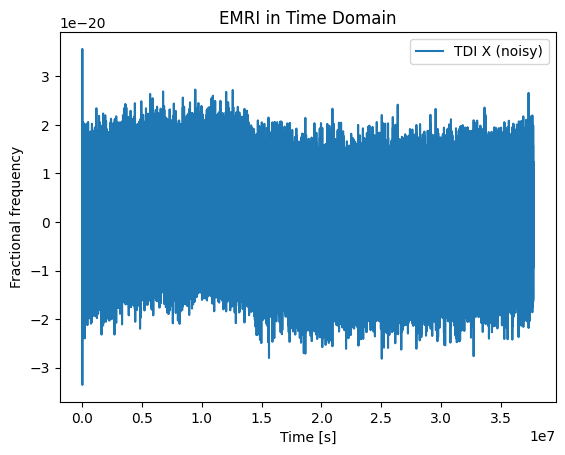

In [48]:
df1 = pd.DataFrame(tdi,columns=['Time','TDI X', 'TDI Y', 'TDI Z']) #noiseless data
print("Noiseless dataframe:")
print(df1)
df1_noise = pd.DataFrame(td_noise,columns=['Time','TDI X (noisy)', 'TDI Y (noisy)', 'TDI Z (noisy)']) #noisy data
print("Noisy dataframe:")
print(df1_noise)
plt.figure(1)
ax = df1_noise.iloc[0:2513800].plot(x = 'Time',y = 'TDI X (noisy)')
plt.xlabel("Time [s]")
plt.ylabel("Fractional frequency")
plt.title("EMRI in Time Domain")
df1.iloc[0:2513800].plot(x = 'Time',y = 'TDI X',color='orange')
plt.xlabel("Time [s]")
plt.ylabel("Fractional Frequency")
plt.title("EMRI in Time Domain")
df1_noise.iloc[0:2513800].plot(x = 'Time',y = 'TDI X (noisy)')
df1.iloc[0:2513800].plot(x = 'Time',y = 'TDI X',ax=ax)
plt.xlabel("Time [s]")
plt.ylabel("Fractional frequency")
plt.title("EMRI in Time Domain")
plt.legend(loc='best')
plt.show()

Plot Y-channel data:

<Figure size 640x480 with 0 Axes>

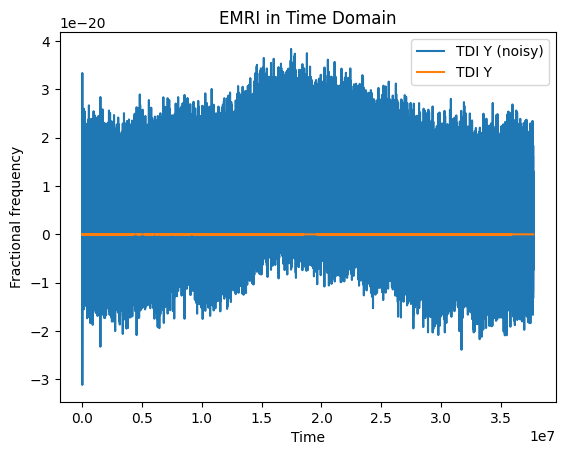

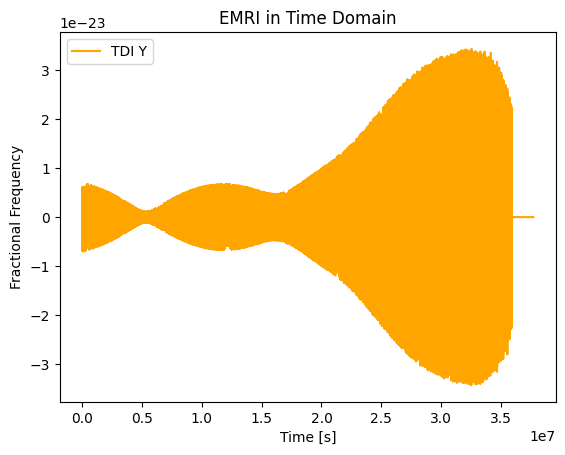

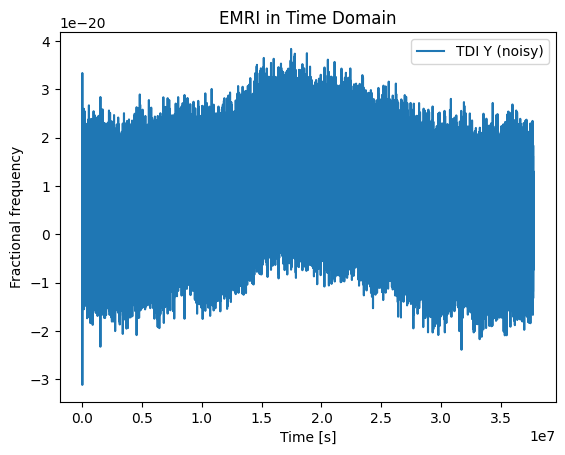

In [49]:
plt.figure(1)
ax = df1_noise.iloc[0:2513800].plot(x = 'Time',y = 'TDI Y (noisy)')
plt.xlabel("Time [s]")
plt.ylabel("Fractional frequency")
plt.title("EMRI in Time Domain")
df1.iloc[0:2513800].plot(x = 'Time',y = 'TDI Y',color='orange')
plt.xlabel("Time [s]")
plt.ylabel("Fractional Frequency")
plt.title("EMRI in Time Domain")
df1_noise.iloc[0:2513800].plot(x = 'Time',y = 'TDI Y (noisy)')
df1.iloc[0:2513800].plot(x = 'Time',y = 'TDI Y',ax=ax)
plt.xlabel("Time [s]")
plt.ylabel("Fractional frequency")
plt.title("EMRI in Time Domain")
plt.legend(loc='best')
plt.show()

Plot Z-channel data:

<Figure size 640x480 with 0 Axes>

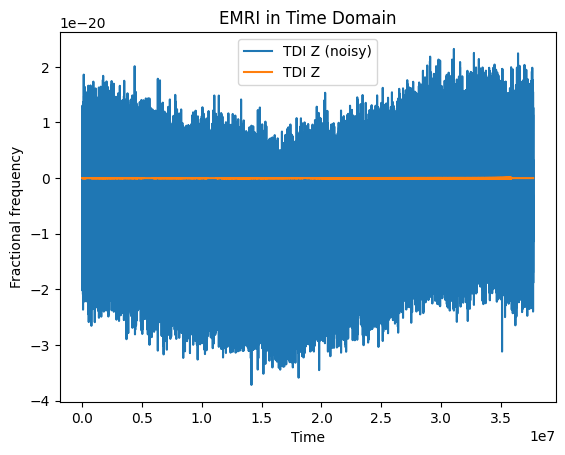

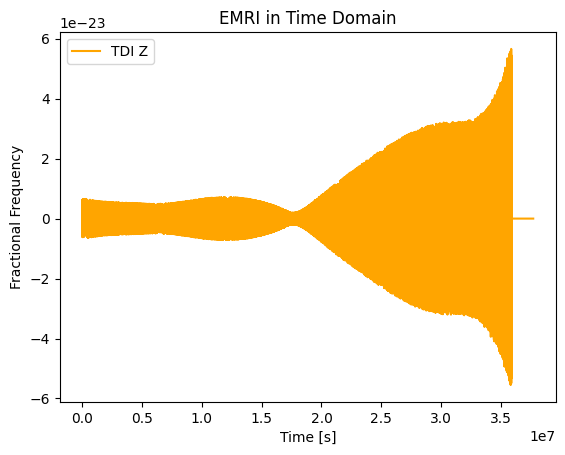

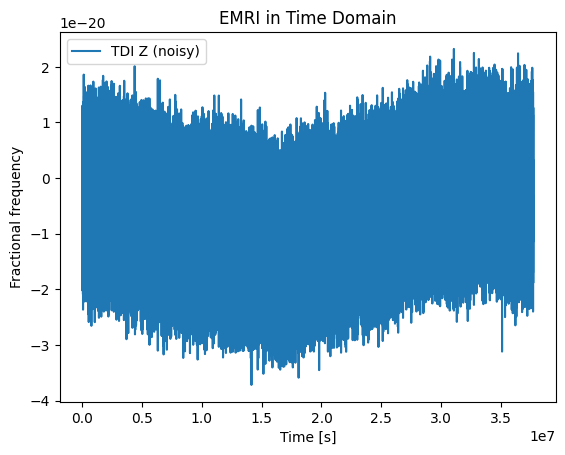

In [50]:
plt.figure(1)
ax = df1_noise.iloc[0:2513800].plot(x = 'Time',y = 'TDI Z (noisy)')
plt.xlabel("Time [s]")
plt.ylabel("Fractional frequency")
plt.title("EMRI in Time Domain")
df1.iloc[0:2513800].plot(x = 'Time',y = 'TDI Z',color='orange')
plt.xlabel("Time [s]")
plt.ylabel("Fractional Frequency")
plt.title("EMRI in Time Domain")
df1_noise.iloc[0:2513800].plot(x = 'Time',y = 'TDI Z (noisy)')
df1.iloc[0:2513800].plot(x = 'Time',y = 'TDI Z',ax=ax)
plt.xlabel("Time [s]")
plt.ylabel("Fractional frequency")
plt.title("EMRI in Time Domain")
plt.legend(loc='best')
plt.show()

Plot noiseless signal in all channels:

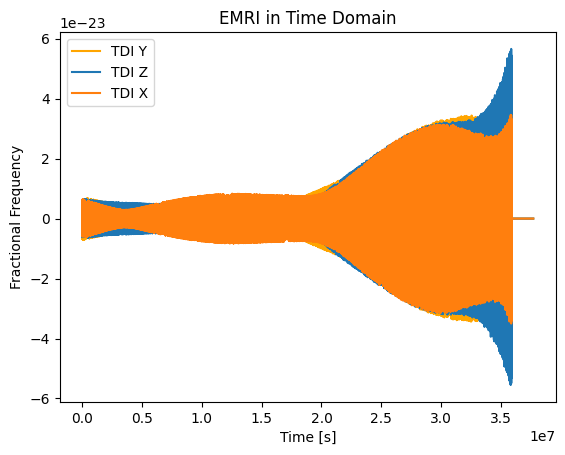

In [51]:
ax = df1.iloc[0:2513800].plot(x = 'Time',y = 'TDI Y',color='orange')
df1.iloc[0:2513800].plot(x = 'Time',y = 'TDI Z',ax=ax)
df1.iloc[0:2513800].plot(x = 'Time',y = 'TDI X',ax=ax)
plt.xlabel("Time [s]")
plt.ylabel("Fractional Frequency")
plt.title("EMRI in Time Domain")
plt.legend(loc='best')
plt.show()

#### 2.4 Plot the TDI data in the frequency domain

Define tapering window to decrease spectral leakage:

In [53]:
def Window(tm):

    xl = 1000.0
    ind_r = np.argwhere(tm[-1]-tm <= 1000.0)[0][0]
    print(ind_r)
    xr = tm[ind_r]
    print(xr)
    kap = 0.005
    winl = 0.5*(1.0 + np.tanh(kap*(tm-xl)))
    winr = 0.5*(1.0 - np.tanh(kap*(tm-xr)))
    return (winl*winr)

Noiseless data:

In [54]:
# Number of points in the time series
Npts = 2**22

#tdi is a list of tuples, in order to index properly covert to 2d array:
tdiList = tdi.tolist()
tdiArr = np.asarray(tdiList)
print(tdiArr)

# Tapering window to mitigate leakage
wind = Window(tdiArr[:Npts,0]) 
# Create frequency data matrix
td_freq = np.zeros(np.shape(tdiArr[:Npts,:]),dtype = np.complex128)
# Take discrete Fourier transform of the noiseless data
td_freq[:,1:] = np.array( [ np.fft.fft(tdiArr[:Npts,i]*wind,axis = 0) for i in range(1,4)] ).T
# Compute corresponding frequency vector
freq = np.fft.fftfreq(Npts)/del_t
td_freq[:,0] = freq
# Store the amplitude modulus in data frame (positive frequencies)
td_freq_plot = np.zeros(np.shape(td_freq[freq>0,:]),dtype = np.float64) 
td_freq_plot[:,0] = freq[freq>0]
# Apply right normalization to get amplitudes 
td_freq_plot[:,1:] = np.abs(td_freq[freq>0,1:])*2/np.sum(wind)
df2 = pd.DataFrame(td_freq_plot,columns=['freq','TDI X', 'TDI Y', 'TDI Z'])

print(df2)

[[ 1.50000000e+001 -4.58981292e-025  7.45420758e-025  1.38357709e-025]
 [ 3.00000000e+001 -3.77948243e-026  1.39549612e-024 -3.19010828e-024]
 [ 4.50000000e+001  1.23236146e-024  1.52341841e-024 -2.68315332e-025]
 ...
 [ 6.29145450e+007  2.47032823e-323  1.67982320e-322 -3.11261357e-322]
 [ 6.29145600e+007 -1.33397724e-322 -8.39911598e-323  2.02566915e-322]
 [ 6.29145750e+007  1.43279037e-322  2.47032823e-323  0.00000000e+000]]
4194237
62913570.0
                 freq         TDI X         TDI Y         TDI Z
0        1.589457e-08  3.007885e-31  3.305478e-31  6.305314e-31
1        3.178914e-08  3.007892e-31  3.305450e-31  6.305291e-31
2        4.768372e-08  3.007861e-31  3.305522e-31  6.305333e-31
3        6.357829e-08  3.007987e-31  3.305333e-31  6.305269e-31
4        7.947286e-08  3.007758e-31  3.305705e-31  6.305413e-31
...               ...           ...           ...           ...
2097146  3.333325e-02  3.417608e-35  4.408534e-35  4.088968e-35
2097147  3.333327e-02  4.004962e-35  

Noisy data:

In [55]:
#td_noise is a list of tuples, in order to index properly covert to 2d array:
print(td_noise)
tdnList = td_noise.tolist()
tdnArr = np.asarray(tdnList)
print(tdnArr)

td_noise_freq = np.zeros(np.shape(tdnArr[:Npts,:]),dtype = np.complex128)
# Take discrete Fourier transform of the noiseless data
td_noise_freq[:,1:] = np.array( [ np.fft.fft(tdnArr[:Npts,i]*wind,axis = 0) for i in range(1,4)] ).T
# Corresponding frequency vector
td_noise_freq[:,0] = freq
# Store the amplitude modulus in data frame (positive frequencies)
td_freq_plot = np.zeros(np.shape(td_noise_freq[freq>0,:]),dtype = np.float64) 
td_freq_plot[:,0] = freq[freq>0]
# Apply right normalization to get amplitudes 
td_freq_plot[:,1:] = np.abs(td_noise_freq[freq>0,1:])*2/np.sum(wind)
df2_noise = pd.DataFrame(td_freq_plot,columns=['freq','TDI X (noisy)', 'TDI Y (noisy)', 'TDI Z (noisy)'])

[(1.5000000e+01, -1.99406686e-20, -8.42435443e-21, -3.58343997e-21)
 (3.0000000e+01, -2.73159865e-21,  3.15585389e-20, -3.70119294e-21)
 (4.5000000e+01,  2.20369762e-20, -3.11280877e-20, -8.46007401e-21) ...
 (6.2914545e+07,  1.11574684e-21,  4.63215959e-22, -1.91249314e-21)
 (6.2914560e+07,  1.43653517e-21, -1.11202353e-20,  9.81482476e-22)
 (6.2914575e+07,  2.05345914e-20, -8.15947858e-21, -1.61145429e-21)]
[[ 1.50000000e+01 -1.99406686e-20 -8.42435443e-21 -3.58343997e-21]
 [ 3.00000000e+01 -2.73159865e-21  3.15585389e-20 -3.70119294e-21]
 [ 4.50000000e+01  2.20369762e-20 -3.11280877e-20 -8.46007401e-21]
 ...
 [ 6.29145450e+07  1.11574684e-21  4.63215959e-22 -1.91249314e-21]
 [ 6.29145600e+07  1.43653517e-21 -1.11202353e-20  9.81482476e-22]
 [ 6.29145750e+07  2.05345914e-20 -8.15947858e-21 -1.61145429e-21]]


Plots:

<Figure size 640x480 with 0 Axes>

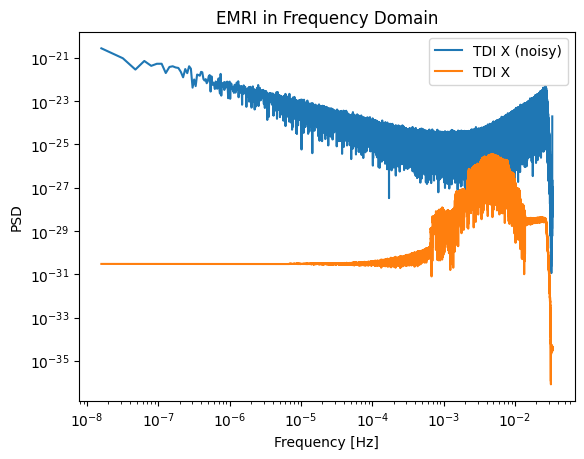

In [56]:
# Plot the Fourier amplitudes
plt.figure(3)
ax2 = df2_noise.plot(x = 'freq',y = 'TDI X (noisy)',logx=True,logy=True)
df2.plot(x = 'freq',y = 'TDI X',logx=True,logy=True,ax = ax2)
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD")
plt.title("EMRI in Frequency Domain")
plt.legend(loc='best')
plt.savefig('frequencyEMRI.pdf')

In [57]:
# find frequency where amplitude peaks (noiseless data)
condition = np.mod(df2.iloc[:,1], max(df2.iloc[:,1]))==0
middleAll = [np.extract(condition,df2.iloc[:,0])]
fPeak = middleAll[0][0]

print(fPeak)

0.004850896199544271


### 3. Compute signal-to-noise ratio

#### 3.1 Consider X channel only

In [58]:
# Consider Fourier-transformed TDI X channel only
Xdf = td_freq[:,1]*del_t
# Consider positive frequencies only
inds = np.where(freq>0)[0]

#### 3.2 Get noise curve


In [ ]:
import importlib  
noise = importlib.import_module("LDC-master.ldc.lisa.noise") 

In [ ]:
noise_model = noise.AnalyticNoise(freq[inds], model='Proposal', wd=0)
Sx = noise_model.psd(freq=freq[inds], option='X')

Alternative approach (LDC-master changes often and the noise module is unreliable):

In [66]:
# Get the empty noise curve by subtracting the signal from the signal + noise
noise = df2_noise
noise['TDI X (noisy)'].subtract(df2['TDI X'])
noise['TDI Y (noisy)'].subtract(df2['TDI Y'])
noise['TDI Z (noisy)'].subtract(df2['TDI Z'])
noise

,freq,TDI X (noisy),TDI Y (noisy),TDI Z (noisy)
0,1.589457e-08,2.729593e-21,7.479152e-21,5.353304e-21
1,3.178914e-08,9.506540e-22,2.168649e-21,2.807266e-21
2,4.768372e-08,2.854469e-22,8.381304e-22,6.135981e-22
3,6.357829e-08,7.106832e-22,1.504254e-21,8.009649e-22
4,7.947286e-08,4.235614e-22,4.069397e-22,3.880505e-22
...,...,...,...,...
2097146,3.333325e-02,8.344763e-25,7.844082e-25,2.876925e-25
2097147,3.333327e-02,1.686932e-24,1.159211e-24,2.762911e-25
2097148,3.333329e-02,6.000724e-25,6.250653e-25,1.121591e-24
2097149,3.333330e-02,1.646919e-24,1.645747e-24,1.093310e-24


#### 3.3 Compute SNR


In [ ]:
# Frequency resolution
df = 1/Tobs
# SNR 
SNR_X = (4.0*df) * np.sum(np.abs(Xdf[inds])**2/Sx)
print("Computed SNR is " + str(np.sqrt(SNR_X)))

### 4. Split data by month

<ipython-input-80-435b6beb63e9>:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

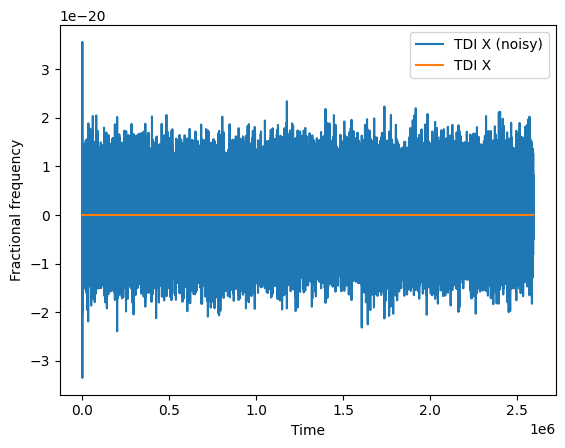

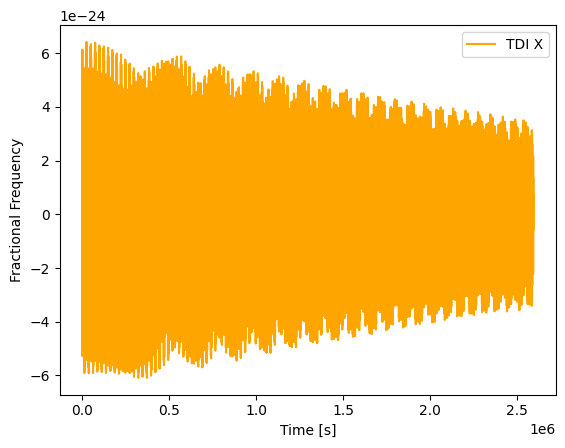

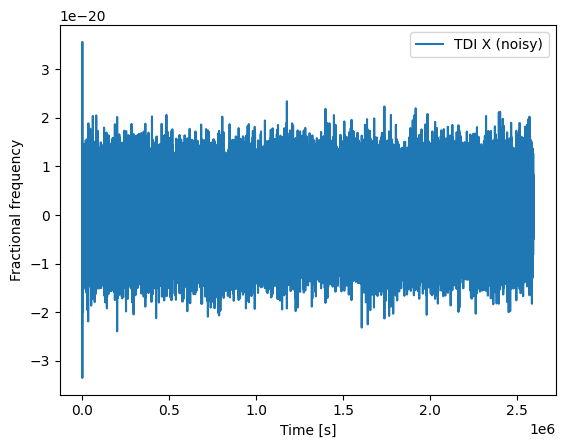

<Figure size 640x480 with 0 Axes>

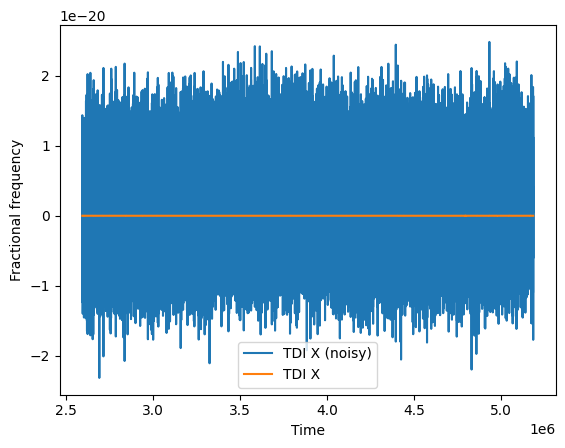

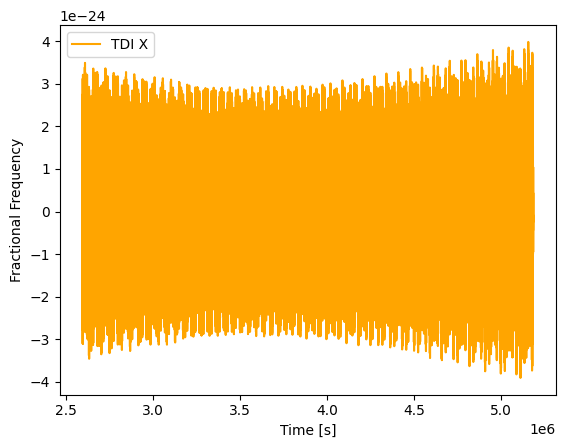

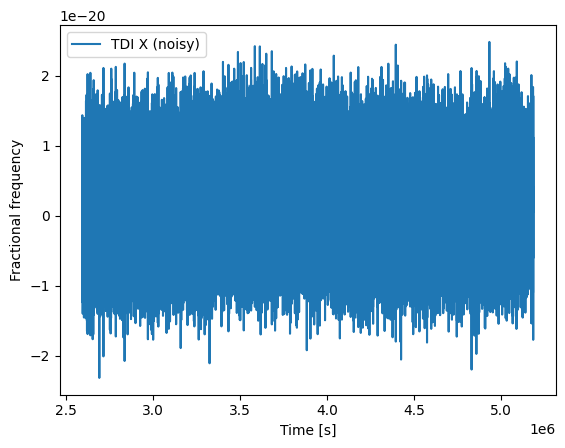

<Figure size 640x480 with 0 Axes>

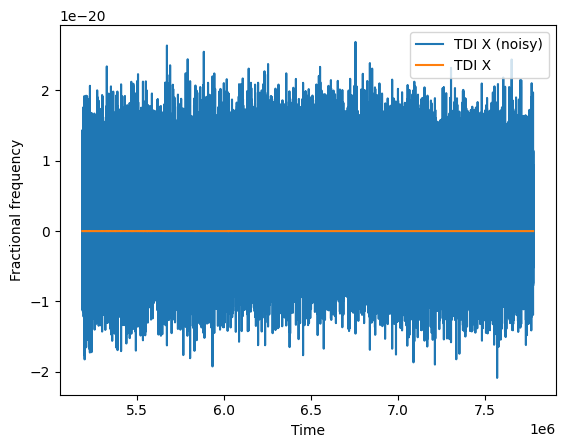

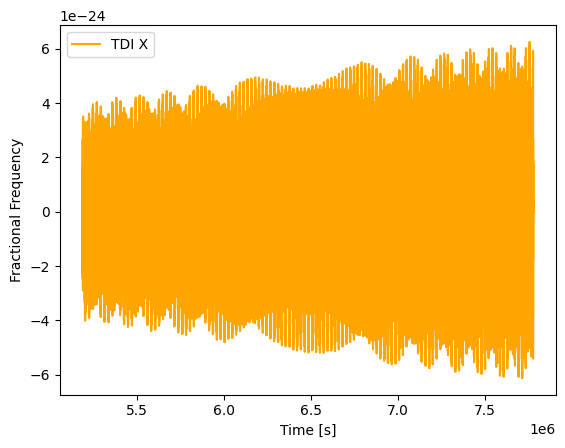

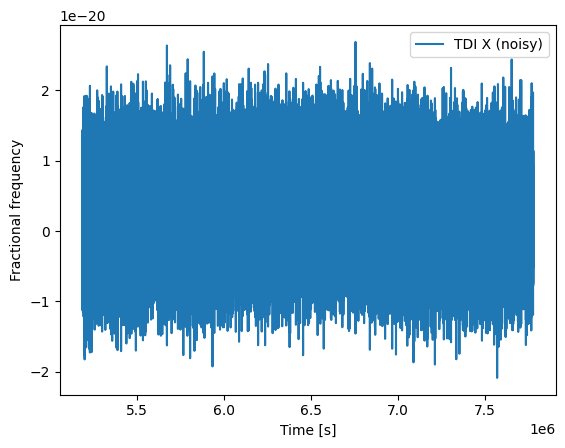

<Figure size 640x480 with 0 Axes>

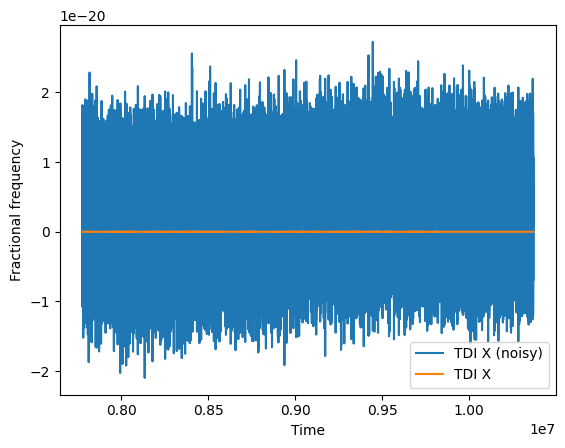

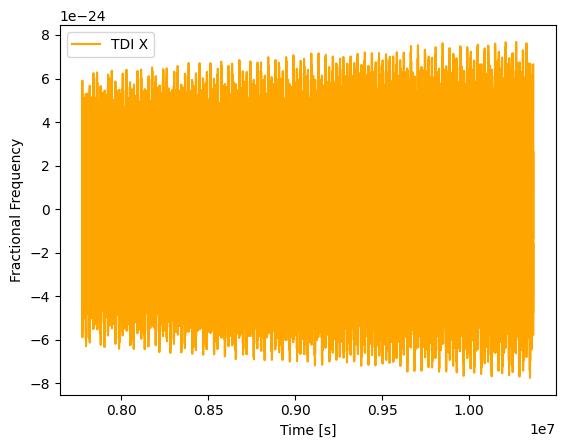

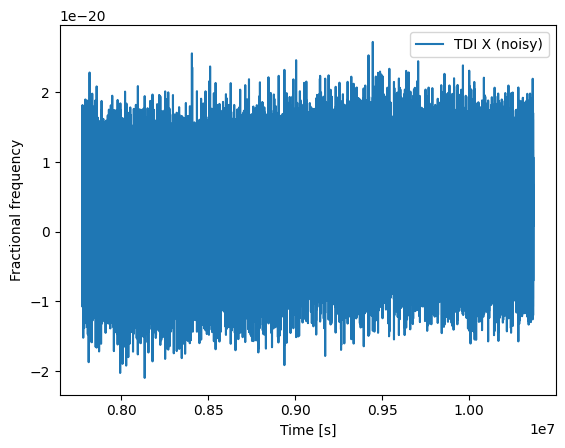

<Figure size 640x480 with 0 Axes>

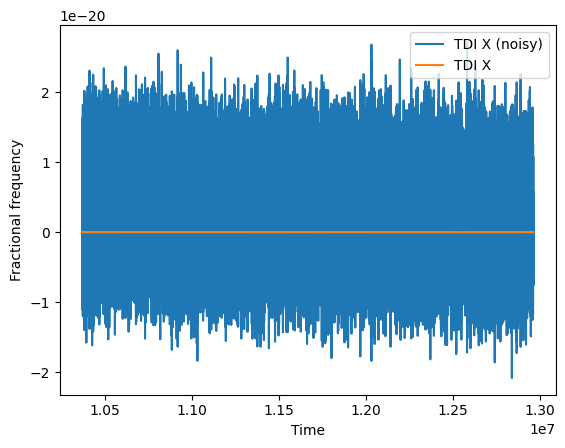

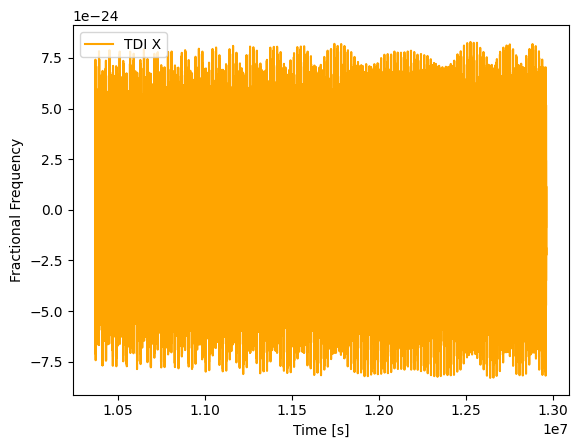

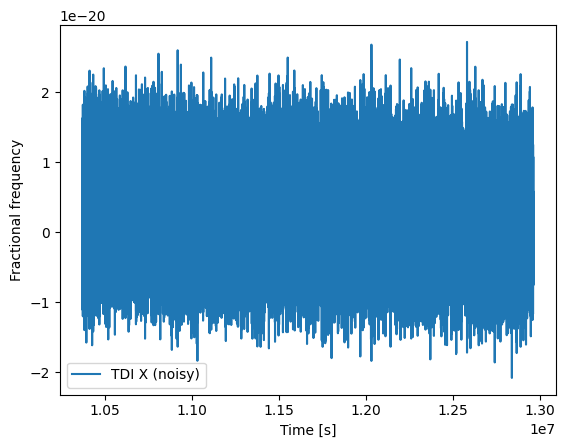

<Figure size 640x480 with 0 Axes>

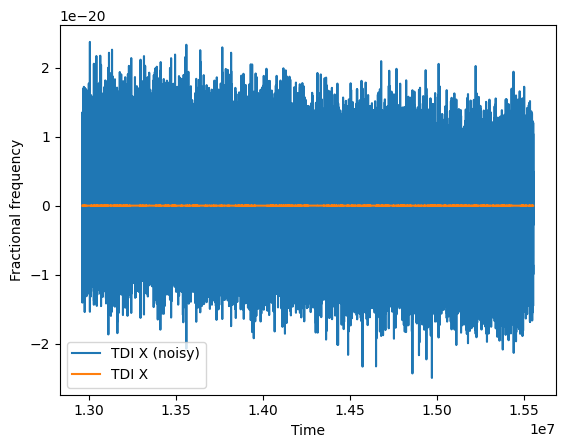

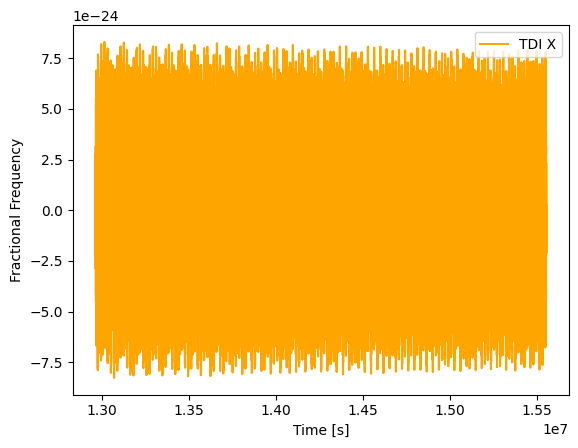

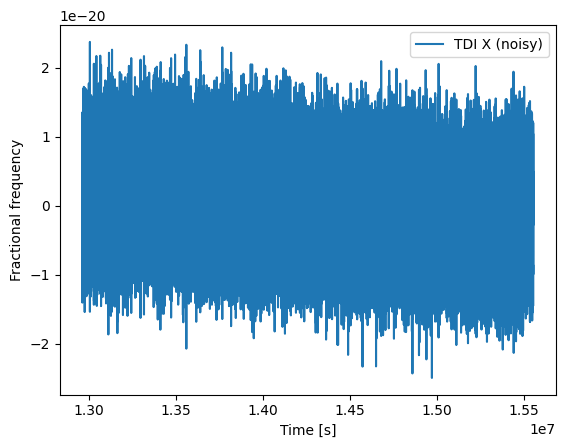

<Figure size 640x480 with 0 Axes>

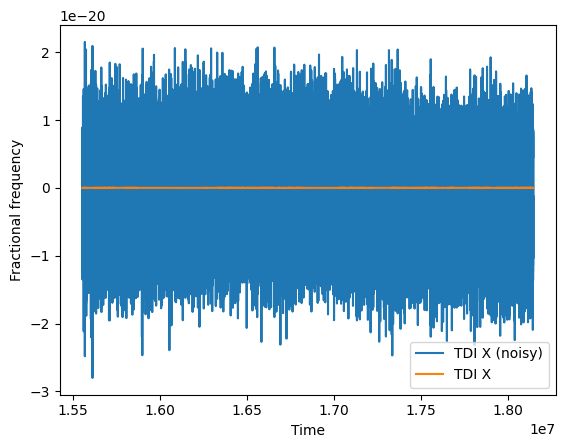

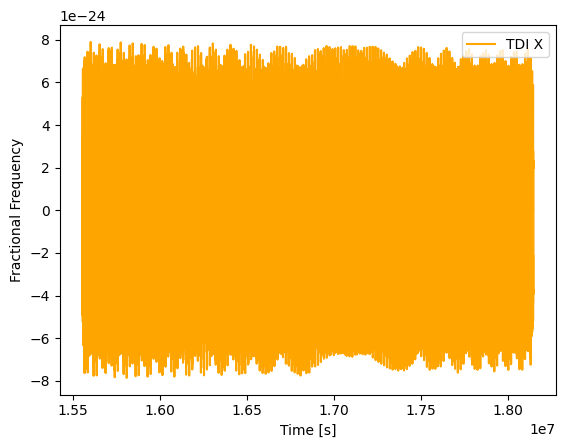

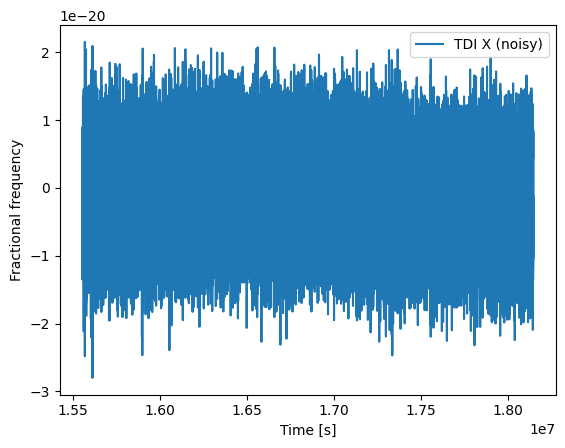

<Figure size 640x480 with 0 Axes>

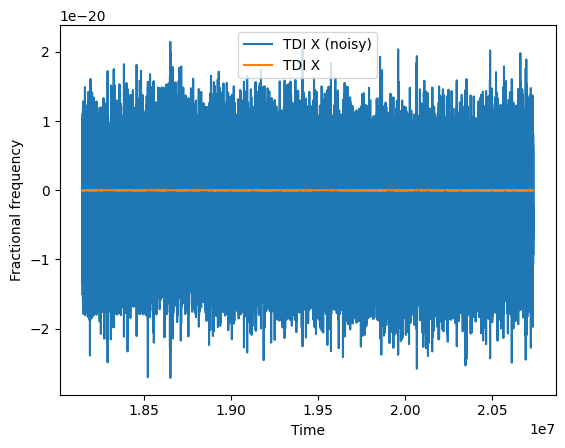

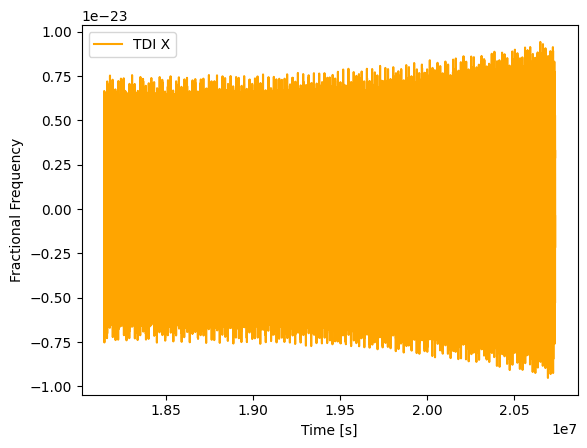

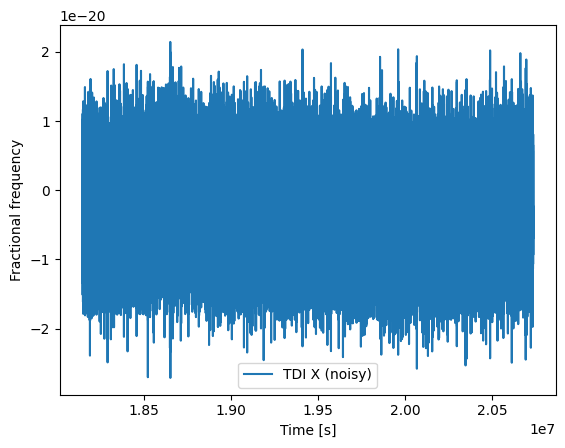

<Figure size 640x480 with 0 Axes>

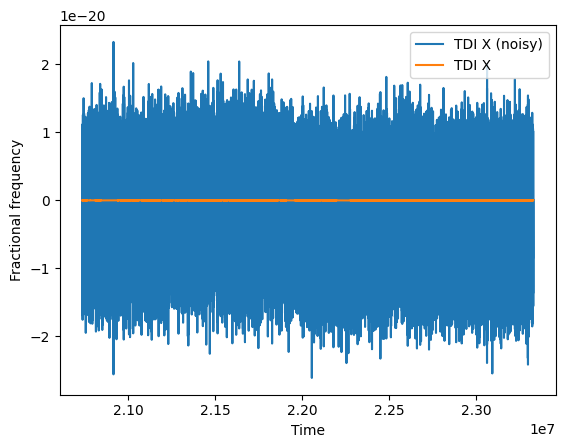

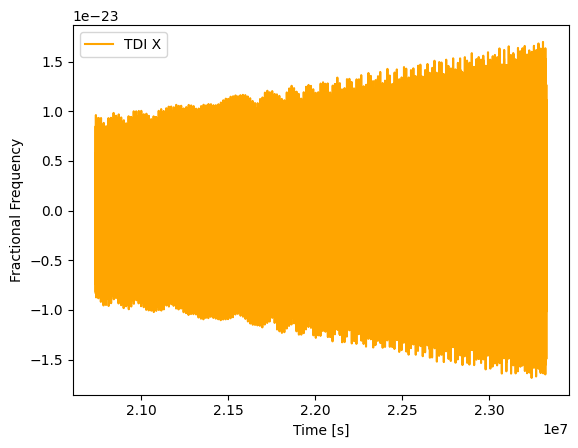

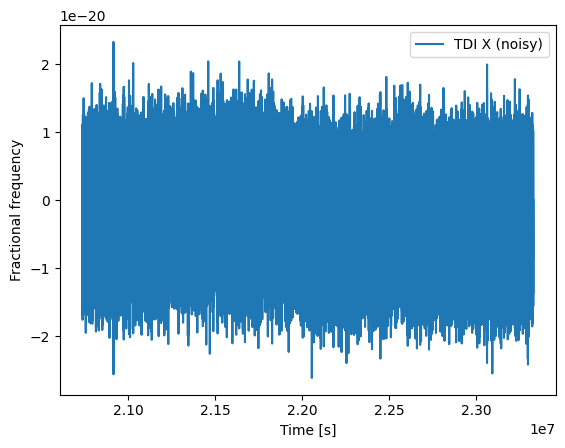

<Figure size 640x480 with 0 Axes>

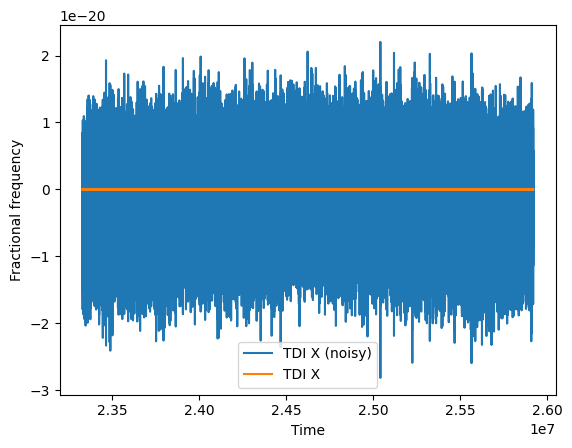

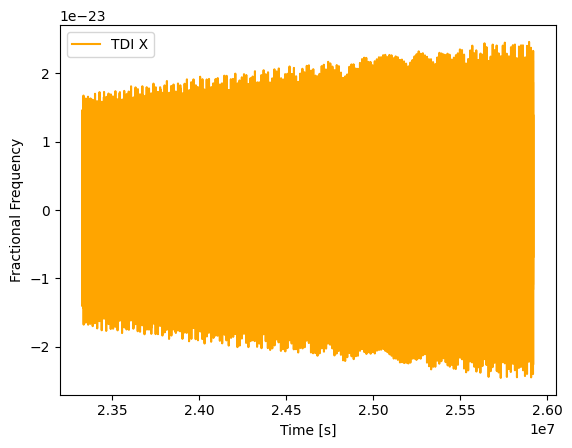

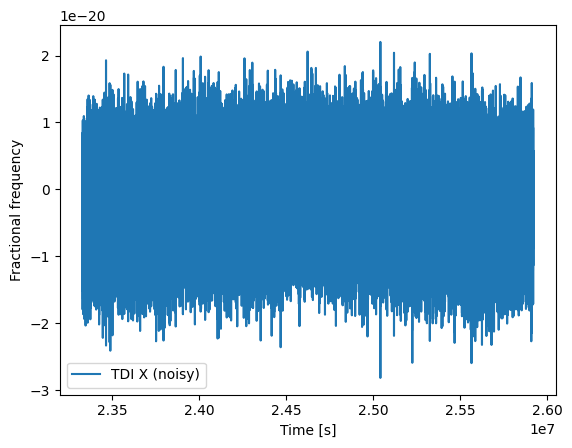

<Figure size 640x480 with 0 Axes>

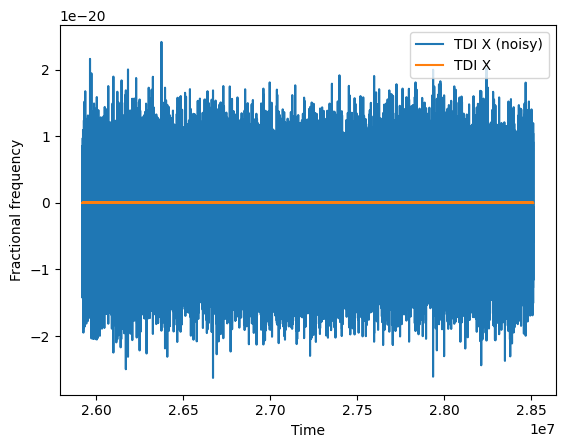

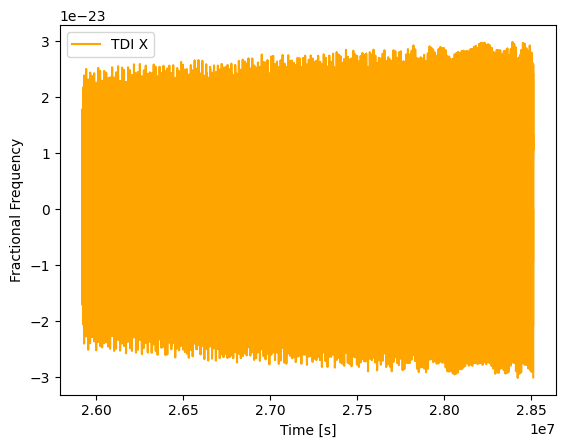

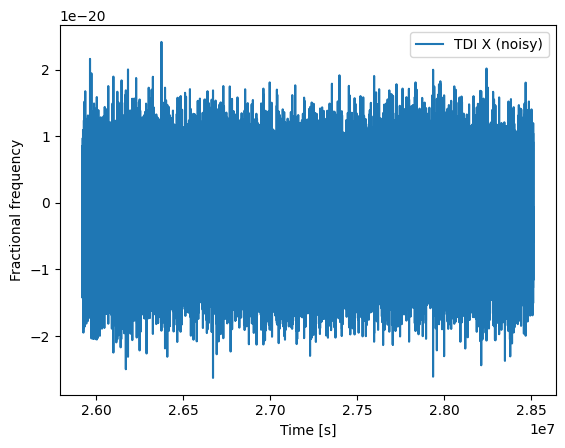

<Figure size 640x480 with 0 Axes>

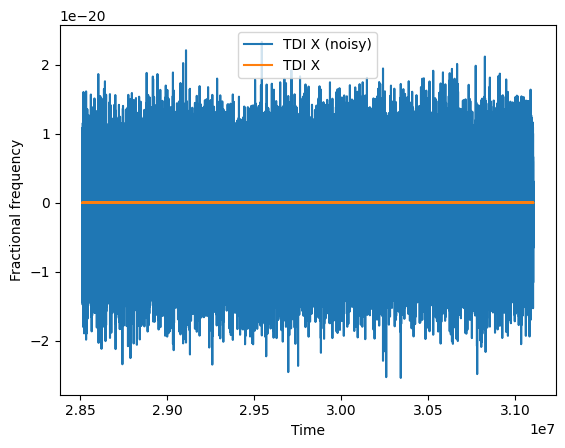

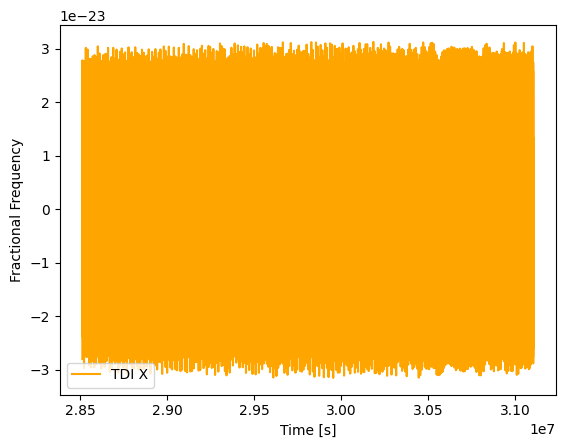

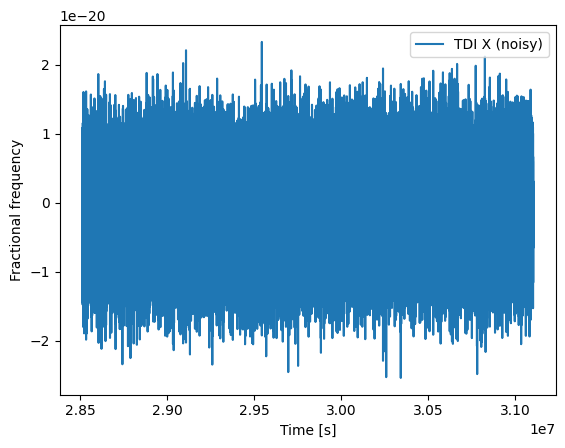

<Figure size 640x480 with 0 Axes>

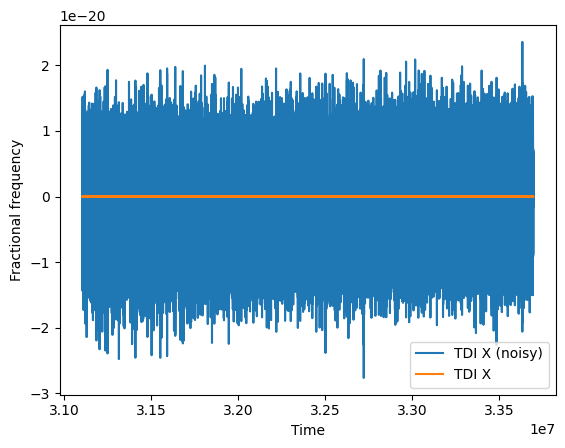

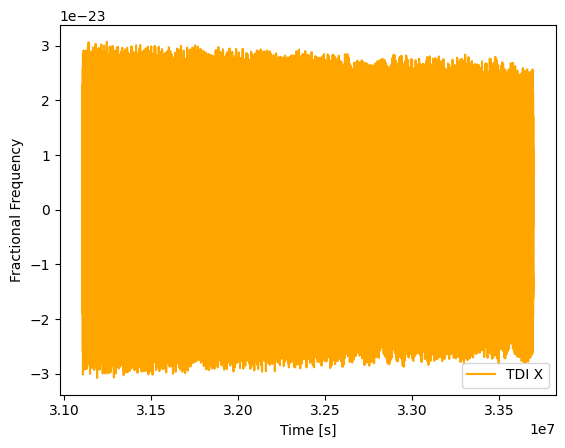

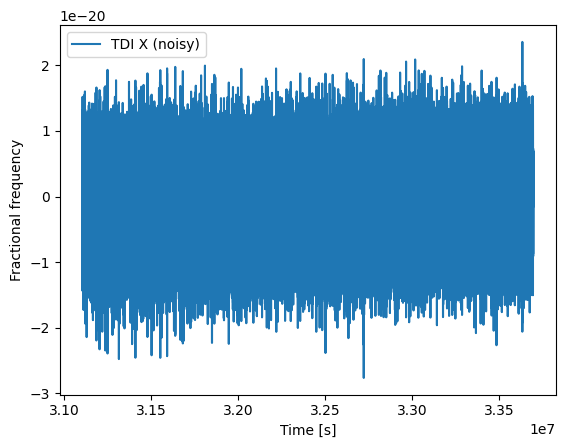

<Figure size 640x480 with 0 Axes>

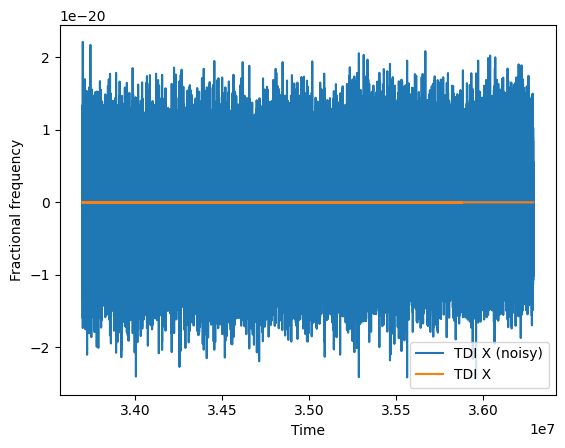

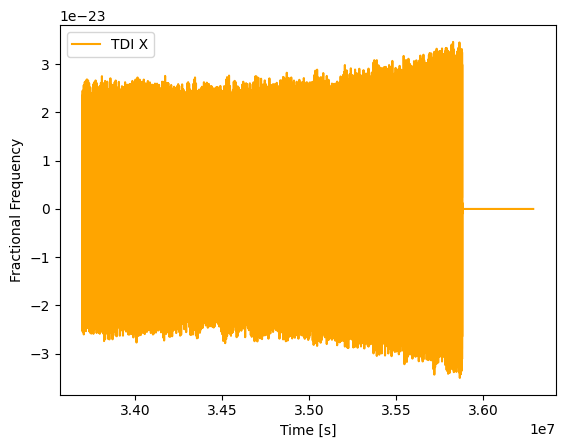

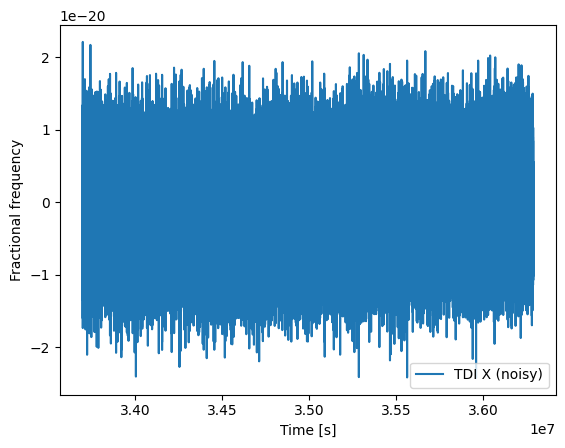

In [80]:
#CAUTION: CELL TAKES A WHILE TO PLOT ALL THE GRAPHS 

#there are 2 years of data, 10 months of which are empty (post-merger)

# make dictionaries of dataframes holding the monthly data
months={}
months_noise={}
upper = int(2.592E6/15)  #2.592E6 seconds in 30 days, but data is downsampled to every 15 s
lower = 0
index = 0
while upper < len(df1):
    months[index]=df1[lower:upper]
    months_noise[index]=df1_noise[lower:upper]
    upper += int(2.592E6/15) #s
    lower += int(2.592E6/15) #s
    index += 1

#plot the signal and/or noise for each interesting month
for key in months:
    plt.figure()
    ax = months_noise[key].iloc[0:2513800].plot(x = 'Time',y = 'TDI X (noisy)')
    plt.xlabel("Time [s]")
    plt.ylabel("Fractional frequency")
    months[key].iloc[0:2513800].plot(x = 'Time',y = 'TDI X',color='orange')
    plt.xlabel("Time [s]")
    plt.ylabel("Fractional Frequency")
    months_noise[key].iloc[0:2513800].plot(x = 'Time',y = 'TDI X (noisy)')
    months[key].iloc[0:2513800].plot(x = 'Time',y = 'TDI X',ax=ax)
    plt.xlabel("Time [s]")
    plt.ylabel("Fractional frequency")
    plt.legend(loc='best')

    if key >= 13:  #the last 10 months are empty, only plot one empty month to improve runtime
      break

plt.show()

<Figure size 640x480 with 0 Axes>

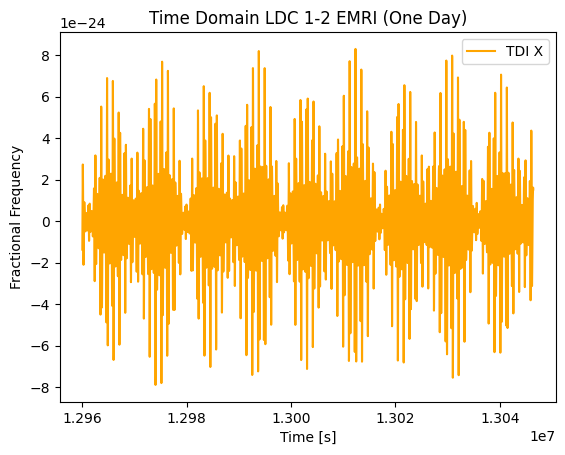

In [81]:
#plot the signal over just one day to show the individual oscillations
plt.figure()
months[5][:5760].iloc[0:2513800].plot(x = 'Time',y = 'TDI X',color='orange')
plt.xlabel("Time [s]")
plt.ylabel("Fractional Frequency")
plt.title("Time Domain LDC 1-2 EMRI (One Day)")
plt.savefig('EMRIday.png')

172733
2591010.0


<Figure size 640x480 with 0 Axes>

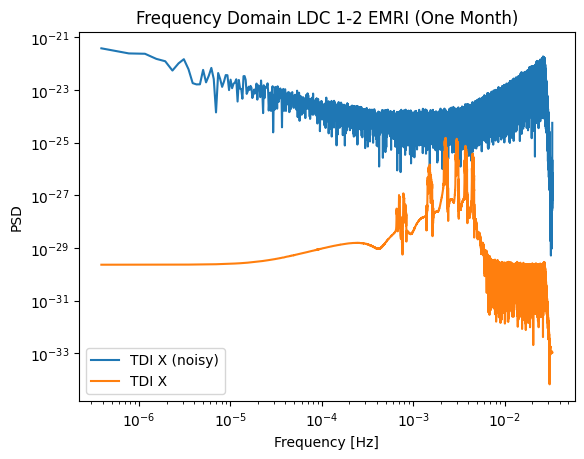

               freq         TDI X         TDI Y         TDI Z
0      3.858025e-07  2.306238e-30  6.081370e-30  8.392154e-30
1      7.716049e-07  2.306916e-30  6.081385e-30  8.392330e-30
2      1.157407e-06  2.308960e-30  6.081273e-30  8.393389e-30
3      1.543210e-06  2.311162e-30  6.081905e-30  8.395038e-30
4      1.929012e-06  2.313742e-30  6.082780e-30  8.396965e-30
...             ...           ...           ...           ...
86394  3.333140e-02  1.062088e-33  8.864695e-34  1.093273e-33
86395  3.333179e-02  1.061572e-33  8.860708e-34  1.093051e-33
86396  3.333218e-02  1.061629e-33  8.859305e-34  1.093344e-33
86397  3.333256e-02  1.061788e-33  8.859821e-34  1.093400e-33
86398  3.333295e-02  1.061550e-33  8.858686e-34  1.092976e-33

[86399 rows x 4 columns]
Month  0 : mean 0.016666666666666666
 min: 3.8580246913580245e-07  max: 0.033332947530864195  mid: 0.016666666666666666
better mid: 0.0022600308641975305
172733
5183010.0


<Figure size 640x480 with 0 Axes>

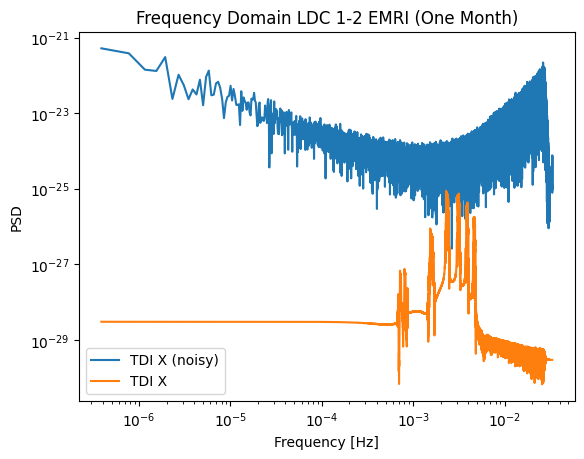

               freq         TDI X         TDI Y         TDI Z
0      3.858025e-07  3.046710e-29  4.577976e-29  7.604453e-29
1      7.716049e-07  3.046741e-29  4.577975e-29  7.604483e-29
2      1.157407e-06  3.046782e-29  4.577991e-29  7.604541e-29
3      1.543210e-06  3.046702e-29  4.577961e-29  7.604429e-29
4      1.929012e-06  3.046669e-29  4.577967e-29  7.604403e-29
...             ...           ...           ...           ...
86394  3.333140e-02  2.991719e-30  3.965627e-30  9.805764e-31
86395  3.333179e-02  2.991718e-30  3.965628e-30  9.805754e-31
86396  3.333218e-02  2.991719e-30  3.965627e-30  9.805765e-31
86397  3.333256e-02  2.991719e-30  3.965628e-30  9.805757e-31
86398  3.333295e-02  2.991720e-30  3.965627e-30  9.805772e-31

[86399 rows x 4 columns]
Month  1 : mean 0.016666666666666666
 min: 3.8580246913580245e-07  max: 0.033332947530864195  mid: 0.016666666666666666
better mid: 0.0022951388888888887
172733
7775010.0


<Figure size 640x480 with 0 Axes>

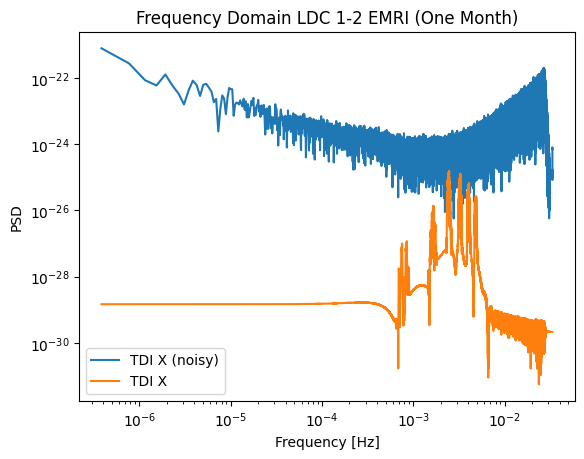

               freq         TDI X         TDI Y         TDI Z
0      3.858025e-07  1.479713e-29  1.637237e-30  1.638452e-29
1      7.716049e-07  1.479720e-29  1.637299e-30  1.638454e-29
2      1.157407e-06  1.479695e-29  1.637935e-30  1.638476e-29
3      1.543210e-06  1.479788e-29  1.637505e-30  1.638499e-29
4      1.929012e-06  1.479688e-29  1.638259e-30  1.638441e-29
...             ...           ...           ...           ...
86394  3.333140e-02  2.162817e-30  9.710451e-31  3.123703e-30
86395  3.333179e-02  2.162817e-30  9.710450e-31  3.123703e-30
86396  3.333218e-02  2.162818e-30  9.710455e-31  3.123703e-30
86397  3.333256e-02  2.162818e-30  9.710450e-31  3.123703e-30
86398  3.333295e-02  2.162818e-30  9.710456e-31  3.123703e-30

[86399 rows x 4 columns]
Month  2 : mean 0.016666666666666666
 min: 3.8580246913580245e-07  max: 0.033332947530864195  mid: 0.016666666666666666
better mid: 0.002464506172839506
172733
10367010.0


<Figure size 640x480 with 0 Axes>

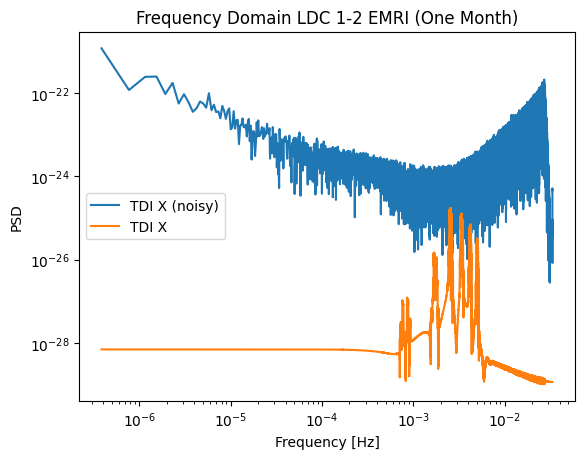

               freq         TDI X         TDI Y         TDI Z
0      3.858025e-07  7.026180e-29  3.791840e-29  1.078927e-28
1      7.716049e-07  7.026156e-29  3.791901e-29  1.078930e-28
2      1.157407e-06  7.026143e-29  3.791922e-29  1.078929e-28
3      1.543210e-06  7.026157e-29  3.791918e-29  1.078929e-28
4      1.929012e-06  7.026161e-29  3.791889e-29  1.078924e-28
...             ...           ...           ...           ...
86394  3.333140e-02  1.160786e-29  9.318612e-30  2.304747e-30
86395  3.333179e-02  1.160786e-29  9.318612e-30  2.304747e-30
86396  3.333218e-02  1.160786e-29  9.318612e-30  2.304747e-30
86397  3.333256e-02  1.160786e-29  9.318612e-30  2.304747e-30
86398  3.333295e-02  1.160786e-29  9.318611e-30  2.304747e-30

[86399 rows x 4 columns]
Month  3 : mean 0.016666666666666666
 min: 3.8580246913580245e-07  max: 0.033332947530864195  mid: 0.016666666666666666
better mid: 0.0025706018518518517
172733
12959010.0


<Figure size 640x480 with 0 Axes>

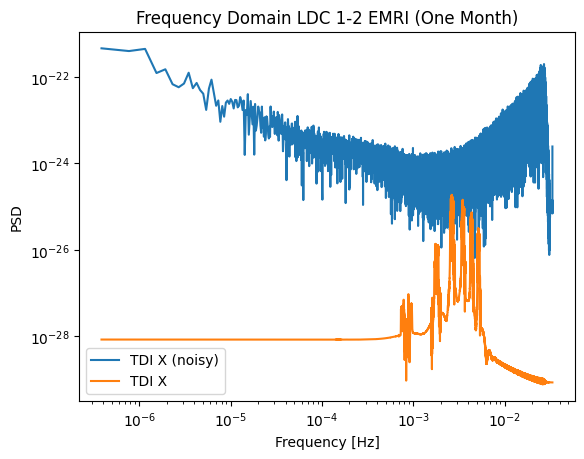

               freq         TDI X         TDI Y         TDI Z
0      3.858025e-07  8.486252e-29  1.291094e-29  9.770388e-29
1      7.716049e-07  8.486282e-29  1.291050e-29  9.770373e-29
2      1.157407e-06  8.486260e-29  1.291077e-29  9.770376e-29
3      1.543210e-06  8.486268e-29  1.291066e-29  9.770371e-29
4      1.929012e-06  8.486285e-29  1.291018e-29  9.770336e-29
...             ...           ...           ...           ...
86394  3.333140e-02  8.658143e-30  1.006411e-29  1.365821e-30
86395  3.333179e-02  8.658143e-30  1.006410e-29  1.365821e-30
86396  3.333218e-02  8.658142e-30  1.006411e-29  1.365820e-30
86397  3.333256e-02  8.658143e-30  1.006410e-29  1.365821e-30
86398  3.333295e-02  8.658143e-30  1.006410e-29  1.365821e-30

[86399 rows x 4 columns]
Month  4 : mean 0.016666666666666666
 min: 3.8580246913580245e-07  max: 0.033332947530864195  mid: 0.016666666666666666
better mid: 0.0026327160493827156
172733
15551010.0


<Figure size 640x480 with 0 Axes>

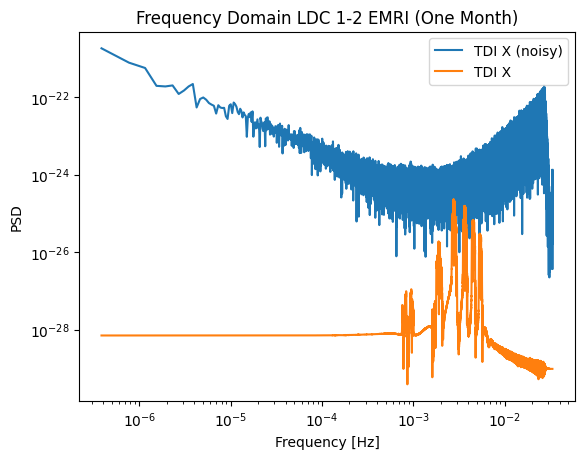

               freq         TDI X         TDI Y         TDI Z
0      3.858025e-07  7.139842e-29  1.104939e-28  3.877877e-29
1      7.716049e-07  7.139820e-29  1.104937e-28  3.877882e-29
2      1.157407e-06  7.139844e-29  1.104940e-28  3.877883e-29
3      1.543210e-06  7.139727e-29  1.104929e-28  3.877891e-29
4      1.929012e-06  7.139798e-29  1.104937e-28  3.877909e-29
...             ...           ...           ...           ...
86394  3.333140e-02  9.826605e-30  3.992885e-30  1.382733e-29
86395  3.333179e-02  9.826607e-30  3.992887e-30  1.382733e-29
86396  3.333218e-02  9.826607e-30  3.992886e-30  1.382733e-29
86397  3.333256e-02  9.826607e-30  3.992886e-30  1.382733e-29
86398  3.333295e-02  9.826606e-30  3.992885e-30  1.382733e-29

[86399 rows x 4 columns]
Month  5 : mean 0.016666666666666666
 min: 3.8580246913580245e-07  max: 0.033332947530864195  mid: 0.016666666666666666
better mid: 0.002759645061728395
172733
18143010.0


<Figure size 640x480 with 0 Axes>

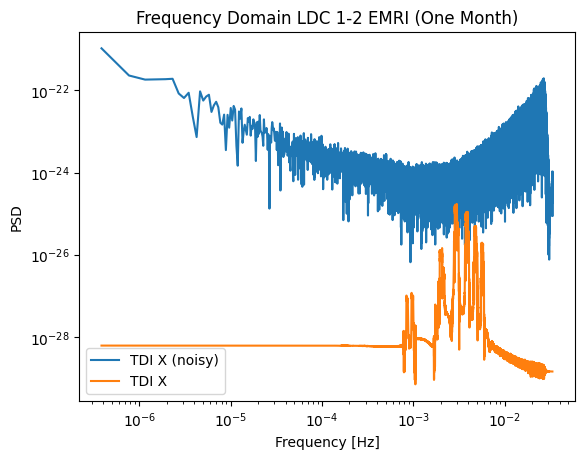

               freq         TDI X         TDI Y         TDI Z
0      3.858025e-07  6.147136e-29  5.343546e-30  6.702954e-29
1      7.716049e-07  6.147160e-29  5.343358e-30  6.702957e-29
2      1.157407e-06  6.147299e-29  5.342558e-30  6.703015e-29
3      1.543210e-06  6.147082e-29  5.344243e-30  6.702962e-29
4      1.929012e-06  6.147221e-29  5.343318e-30  6.703006e-29
...             ...           ...           ...           ...
86394  3.333140e-02  1.438626e-29  2.775584e-30  1.165430e-29
86395  3.333179e-02  1.438627e-29  2.775581e-30  1.165430e-29
86396  3.333218e-02  1.438626e-29  2.775583e-30  1.165430e-29
86397  3.333256e-02  1.438626e-29  2.775584e-30  1.165430e-29
86398  3.333295e-02  1.438627e-29  2.775582e-30  1.165430e-29

[86399 rows x 4 columns]
Month  6 : mean 0.016666666666666666
 min: 3.8580246913580245e-07  max: 0.033332947530864195  mid: 0.016666666666666666
better mid: 0.0029872685185185184
172733
20735010.0


<Figure size 640x480 with 0 Axes>

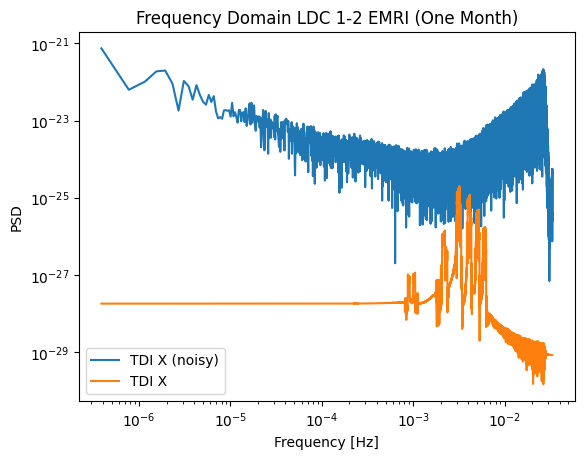

               freq         TDI X         TDI Y         TDI Z
0      3.858025e-07  1.826944e-28  1.479845e-28  3.523680e-29
1      7.716049e-07  1.826944e-28  1.479847e-28  3.523658e-29
2      1.157407e-06  1.826938e-28  1.479833e-28  3.523733e-29
3      1.543210e-06  1.826934e-28  1.479842e-28  3.523603e-29
4      1.929012e-06  1.826946e-28  1.479836e-28  3.523791e-29
...             ...           ...           ...           ...
86394  3.333140e-02  8.518700e-30  1.468715e-29  6.151949e-30
86395  3.333179e-02  8.518703e-30  1.468715e-29  6.151950e-30
86396  3.333218e-02  8.518700e-30  1.468715e-29  6.151949e-30
86397  3.333256e-02  8.518702e-30  1.468715e-29  6.151950e-30
86398  3.333295e-02  8.518701e-30  1.468715e-29  6.151949e-30

[86399 rows x 4 columns]
Month  7 : mean 0.016666666666666666
 min: 3.8580246913580245e-07  max: 0.033332947530864195  mid: 0.016666666666666666
better mid: 0.003203317901234568
172733
23327010.0


<Figure size 640x480 with 0 Axes>

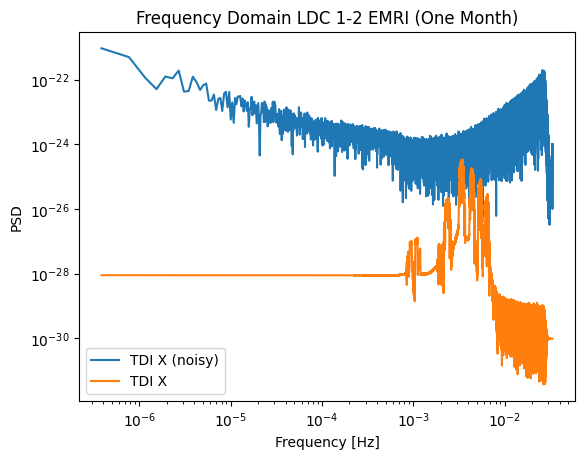

               freq         TDI X         TDI Y         TDI Z
0      3.858025e-07  8.907453e-29  4.505807e-29  4.420561e-29
1      7.716049e-07  8.907404e-29  4.505793e-29  4.420527e-29
2      1.157407e-06  8.907516e-29  4.505736e-29  4.420697e-29
3      1.543210e-06  8.907398e-29  4.505765e-29  4.420550e-29
4      1.929012e-06  8.907370e-29  4.505855e-29  4.420433e-29
...             ...           ...           ...           ...
86394  3.333140e-02  9.604011e-31  8.411601e-30  7.474152e-30
86395  3.333179e-02  9.603988e-31  8.411604e-30  7.474149e-30
86396  3.333218e-02  9.604007e-31  8.411601e-30  7.474151e-30
86397  3.333256e-02  9.604019e-31  8.411600e-30  7.474152e-30
86398  3.333295e-02  9.604011e-31  8.411601e-30  7.474150e-30

[86399 rows x 4 columns]
Month  8 : mean 0.016666666666666666
 min: 3.8580246913580245e-07  max: 0.033332947530864195  mid: 0.016666666666666666
better mid: 0.003452546296296296
172733
25919010.0


<Figure size 640x480 with 0 Axes>

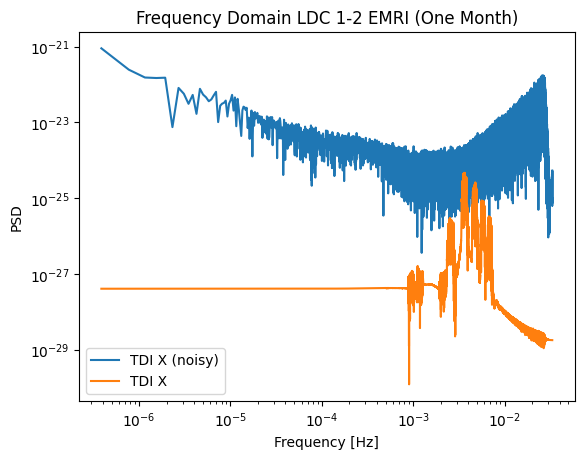

               freq         TDI X         TDI Y         TDI Z
0      3.858025e-07  4.066561e-28  1.573639e-28  2.492193e-28
1      7.716049e-07  4.066559e-28  1.573643e-28  2.492188e-28
2      1.157407e-06  4.066537e-28  1.573637e-28  2.492172e-28
3      1.543210e-06  4.066550e-28  1.573633e-28  2.492189e-28
4      1.929012e-06  4.066576e-28  1.573649e-28  2.492199e-28
...             ...           ...           ...           ...
86394  3.333140e-02  1.785678e-29  7.731672e-29  5.970470e-29
86395  3.333179e-02  1.785678e-29  7.731672e-29  5.970470e-29
86396  3.333218e-02  1.785678e-29  7.731672e-29  5.970471e-29
86397  3.333256e-02  1.785678e-29  7.731672e-29  5.970471e-29
86398  3.333295e-02  1.785678e-29  7.731672e-29  5.970470e-29

[86399 rows x 4 columns]
Month  9 : mean 0.016666666666666666
 min: 3.8580246913580245e-07  max: 0.033332947530864195  mid: 0.016666666666666666
better mid: 0.0036585648148148146
172733
28511010.0


<Figure size 640x480 with 0 Axes>

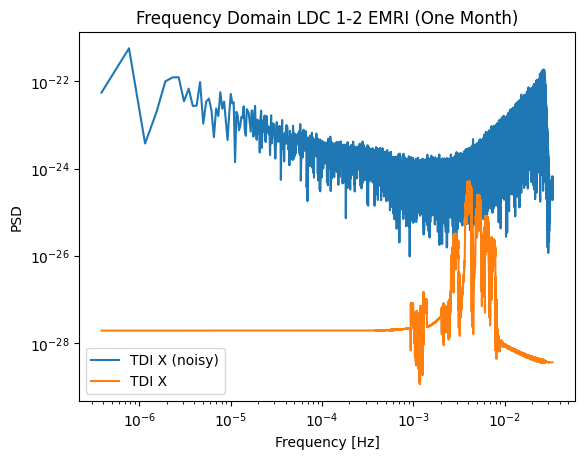

               freq         TDI X         TDI Y         TDI Z
0      3.858025e-07  1.931818e-28  1.040612e-28  2.978102e-28
1      7.716049e-07  1.931824e-28  1.040617e-28  2.978112e-28
2      1.157407e-06  1.931823e-28  1.040611e-28  2.978104e-28
3      1.543210e-06  1.931810e-28  1.040604e-28  2.978084e-28
4      1.929012e-06  1.931818e-28  1.040617e-28  2.978105e-28
...             ...           ...           ...           ...
86394  3.333140e-02  3.618047e-29  4.438364e-29  8.349336e-30
86395  3.333179e-02  3.618047e-29  4.438364e-29  8.349335e-30
86396  3.333218e-02  3.618047e-29  4.438364e-29  8.349333e-30
86397  3.333256e-02  3.618047e-29  4.438364e-29  8.349335e-30
86398  3.333295e-02  3.618047e-29  4.438364e-29  8.349336e-30

[86399 rows x 4 columns]
Month  10 : mean 0.016666666666666666
 min: 3.8580246913580245e-07  max: 0.033332947530864195  mid: 0.016666666666666666
better mid: 0.004107638888888889
172733
31103010.0


<Figure size 640x480 with 0 Axes>

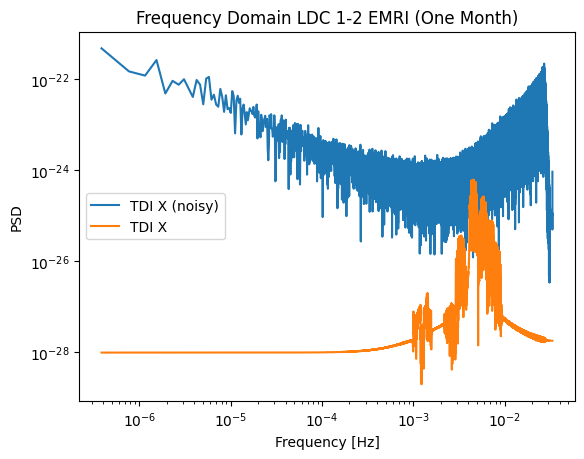

               freq         TDI X         TDI Y         TDI Z
0      3.858025e-07  9.776765e-29  6.113633e-28  7.108222e-28
1      7.716049e-07  9.776860e-29  6.113629e-28  7.108227e-28
2      1.157407e-06  9.776637e-29  6.113647e-28  7.108222e-28
3      1.543210e-06  9.776855e-29  6.113633e-28  7.108229e-28
4      1.929012e-06  9.776851e-29  6.113625e-28  7.108218e-28
...             ...           ...           ...           ...
86394  3.333140e-02  1.779440e-28  1.114879e-28  6.606057e-29
86395  3.333179e-02  1.779440e-28  1.114879e-28  6.606057e-29
86396  3.333218e-02  1.779440e-28  1.114879e-28  6.606057e-29
86397  3.333256e-02  1.779440e-28  1.114879e-28  6.606057e-29
86398  3.333295e-02  1.779440e-28  1.114879e-28  6.606057e-29

[86399 rows x 4 columns]
Month  11 : mean 0.016666666666666666
 min: 3.8580246913580245e-07  max: 0.033332947530864195  mid: 0.016666666666666666
better mid: 0.004547453703703703
172733
33695010.0


<Figure size 640x480 with 0 Axes>

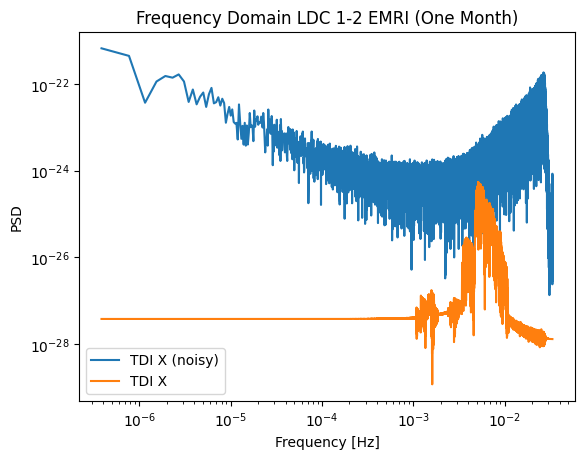

               freq         TDI X         TDI Y         TDI Z
0      3.858025e-07  3.787217e-28  5.899943e-28  2.123851e-28
1      7.716049e-07  3.787235e-28  5.899912e-28  2.123802e-28
2      1.157407e-06  3.787222e-28  5.899972e-28  2.123876e-28
3      1.543210e-06  3.787244e-28  5.899982e-28  2.123863e-28
4      1.929012e-06  3.787142e-28  5.899903e-28  2.123887e-28
...             ...           ...           ...           ...
86394  3.333140e-02  1.299974e-28  1.740207e-29  1.471753e-28
86395  3.333179e-02  1.299974e-28  1.740207e-29  1.471753e-28
86396  3.333218e-02  1.299974e-28  1.740207e-29  1.471753e-28
86397  3.333256e-02  1.299974e-28  1.740205e-29  1.471753e-28
86398  3.333295e-02  1.299974e-28  1.740207e-29  1.471753e-28

[86399 rows x 4 columns]
Month  12 : mean 0.016666666666666666
 min: 3.8580246913580245e-07  max: 0.033332947530864195  mid: 0.016666666666666666
better mid: 0.005140432098765432
172733
36287010.0


<Figure size 640x480 with 0 Axes>

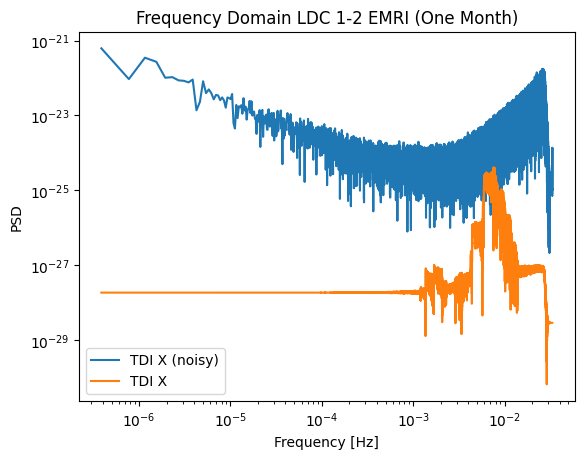

               freq         TDI X         TDI Y         TDI Z
0      3.858025e-07  1.846605e-28  4.893206e-29  2.330358e-28
1      7.716049e-07  1.846573e-28  4.893605e-29  2.330365e-28
2      1.157407e-06  1.846521e-28  4.891989e-29  2.330153e-28
3      1.543210e-06  1.846676e-28  4.891659e-29  2.330274e-28
4      1.929012e-06  1.846474e-28  4.893784e-29  2.330284e-28
...             ...           ...           ...           ...
86394  3.333140e-02  2.878971e-29  7.097720e-29  4.238108e-29
86395  3.333179e-02  2.878986e-29  7.097715e-29  4.238118e-29
86396  3.333218e-02  2.878992e-29  7.097718e-29  4.238121e-29
86397  3.333256e-02  2.878986e-29  7.097716e-29  4.238115e-29
86398  3.333295e-02  2.878963e-29  7.097719e-29  4.238108e-29

[86399 rows x 4 columns]
Month  13 : mean 0.016666666666666666
 min: 3.8580246913580245e-07  max: 0.033332947530864195  mid: 0.016666666666666666
better mid: 0.0076091820987654315


In [82]:
# Convert to frequency space

ifreqs = {}  # initialize dict to store one interesting frequency for each month
list_of_dfs = []
list_of_dfs_noise = []

for key in months: 

    tdiArr6 = np.asarray(months[key])

    #noiseless data:

    wind6 = Window(tdiArr6[:len(months[key]),0])  # can we still use the old window function?
    # Create frequency data matrix
    td_freq6 = np.zeros(np.shape(tdiArr6[:len(months[key]),:]),dtype = np.complex128)
    # Take discrete Fourier transform of the noiseless data
    td_freq6[:,1:] = np.array([np.fft.fft(tdiArr6[:len(months[key]),i]*wind6,axis = 0) for i in range(1,4)] ).T 
    # Compute corresponding frequency vector
    freq6 = np.fft.fftfreq(len(months[key]))/del_t  # this will be constant since length is constant as is del_t...
    td_freq6[:,0] = freq6
    # Store the amplitude modulus in data frame (positive frequencies)
    td_freq_plot6 = np.zeros(np.shape(td_freq6[freq6>0,:]),dtype = np.float64) 
    td_freq_plot6[:,0] = freq6[freq6>0]
    # Apply right normalization to get amplitudes 
    td_freq_plot6[:,1:] = np.abs(td_freq6[freq6>0,1:])*2/np.sum(wind6)
    df2m = pd.DataFrame(td_freq_plot6,columns=['freq','TDI X', 'TDI Y', 'TDI Z'])
    list_of_dfs += [df2m]

    #SNR
    Xd = td_freq6[:,1]*del_t
    ind = np.where(freq6>0)[0]
    #Sxd = noise_model.psd(freq=freq6[ind], option='X')
    #SNRX = (4.0*df) * np.sum(np.abs(Xd[ind])**2/Sxd)
    #print("Computed SNR is " + str(np.sqrt(SNRX)))


    #noisy data:

    tdnArr6 = np.asarray(months_noise[key])

    td_noise_freq6 = np.zeros(np.shape(tdnArr[:len(months[key]),:]),dtype = np.complex128)
    # Take discrete Fourier transform of the noiseless data
    td_noise_freq6[:,1:] = np.array( [np.fft.fft(tdnArr6[:len(months[key]),i]*wind6,axis = 0) for i in range(1,4)] ).T
    # Corresponding frequency vector
    td_noise_freq6[:,0] = freq6
    # Store the amplitude modulus in data frame (positive frequencies)
    td_freq_plot6 = np.zeros(np.shape(td_noise_freq6[freq6>0,:]),dtype = np.float64) 
    td_freq_plot6[:,0] = freq6[freq6>0]
    # Apply right normalization to get amplitudes 
    td_freq_plot6[:,1:] = np.abs(td_noise_freq6[freq6>0,1:])*2/np.sum(wind6)
    df2_noisem = pd.DataFrame(td_freq_plot6,columns=['freq','TDI X (noisy)', 'TDI Y (noisy)', 'TDI Z (noisy)'])
    list_of_dfs_noise += [df2_noisem]

    # Plot the Fourier amplitudes
    plt.figure()
    ax2m = df2_noisem.plot(x = 'freq',y = 'TDI X (noisy)',logx=True,logy=True)
    df2m.plot(x = 'freq',y = 'TDI X',logx=True,logy=True,ax = ax2m)
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("PSD")
    plt.legend(loc='best')
    plt.title('Frequency Domain LDC 1-2 EMRI (One Month)')
    plt.savefig('month' + str(key) + '.png')
    plt.show()

    l = int(len(df2m)/2)

    print(df2m)

    print("Month ", key, ": mean", statistics.mean(df2m.iloc[:,0]))  #trying to find the initial freq since it looks pretty representative for most of the time; this is what we can use later
    print(" min:", min(df2m.iloc[:,0]), " max:", max(df2m.iloc[:,0]), " mid:", df2m.iloc[l,0])
    # find frequency where amplitude peaks
    condition = np.mod(df2m.iloc[:,1], max(df2m.iloc[:,1]))==0
    middle = [np.extract(condition,df2m.iloc[:,0])]
    print("better mid:", middle[0][0])

    ifreqs[key] = middle[0][0]

    if key >= 13:  #the last 10 months are empty, the months dict shouldn't have any of them but the FFT can't run on empty data so this is here to avoid errors just in case
        break

### 5. Produce waveforms

In [ ]:
import ldc.waveform.fastAK as fastAK
from ldc.common.tools import compute_tdi_snr
from ldc.common.series import TDI
from ldc.lisa.noise import get_noise_model

def waveform_from_pars(mass = 1338797.0898213838):
  # 1338797.0898213838 was the previously set MBHMass
  maxDur = 62914560.
  timestep = 15.0
  dtPhase = 2048.
  df = 1.0/maxDur
  Extended = 0
  pars = {'MBHMass': mass,
            'mu': 147.67680599627957, 'spin': 0.508191849430434,
            'lam': 0.5159259750304522, 'thS': 1.9963332443330797,
            'phS': 2.3328932152936743, 'thK': 1.3576019682706004,
            'phK': 4.464051088924649, 'DL': 26079065546.869873,
            'e0': 0.16954807413751763, 'nu0': 0.0014474837386423904,
            'phi0': 4.065749328184277, 
            'alph0': 5.26964680932448, 'gam0': 2.010025317378693,
            't0': 41097264.4945925} 

  ak_fd = fastAK.pyFreqAK_RA(timestep, maxDur, dtPhase, 0)
  Xf, Yf, Zf = ak_fd.get_fd_tdixyz(pars)
  ak_fd.destruct()
  return Xf, Yf, Zf

                                  


Xf, Yf, Zf = waveform_from_pars()
plt.figure
plt.loglog(Xf.f, np.abs(Xf))
plt.show()

cond = np.mod(df2m.iloc[:,1], max(df2m.iloc[:,1]))==0
midd = [np.extract(cond,df2m.iloc[:,0])]
print("better mid:", midd[0][0])

### 6. MCMC

#### 6.0 MCMC installation

In [ ]:
# Install a parallel-tempered MCMC sampler
!pip install ptmcmcsampler

In [ ]:
from PTMCMCSampler import PTMCMCSampler

#### 6.1 Developing a likelihood

In [89]:
def innerProduct(a,b, Sn): # this assumes a and b and Sn are the same size!
  sum = np.sum((a*np.conjugate(b))/Sn) 
  return 4*np.real(sum)

def likelihood(Xinj,Yinj,Zinj,X,Y,Z,noise):
  lnLikely = -0.5*(innerProduct((X-Xinj),(X-Xinj),noise['TDI X (noisy)']) + innerProduct((Y-Yinj),(Y-Yinj) ,noise['TDI Y (noisy)']) + innerProduct((Z-Zinj),(Z-Zinj),noise['TDI Z (noisy)']))
  return lnLikely

#### 6.2 Likelihood Tests

In [90]:
# noiseless signal compared to itself:
likelihood(df2['TDI X'],df2['TDI Y'],df2['TDI Z'], df2['TDI X'],df2['TDI Y'],df2['TDI Z'], noise)

-0.0

In [91]:
#signal compared to noise:
likelihood(noise['TDI X (noisy)'],noise['TDI Y (noisy)'],noise['TDI Z (noisy)'], df2['TDI X'],df2['TDI Y'],df2['TDI Z'], noise)

-3.8459083766130966e-17

In [93]:
#signal compared to 0:
likelihood(0,0,0, df2['TDI X'],df2['TDI Y'],df2['TDI Z'], noise)

-1.653058228497142e-21

In [95]:
# noiseless signal compared to noise+signal:
likelihood(df2['TDI X'],df2['TDI Y'],df2['TDI Z'], df2_noise['TDI Z (noisy)'],df2_noise['TDI X (noisy)'],df2_noise['TDI Y (noisy)'], noise)

-7.480973577986266e-17

#### 6.3 Using PTMCMC sampler

In [96]:
# Initialization of parameters
p0 = np.array([2000000.0])  # initial value of mass; just took one of similar magnitude to the default
ndim = 1  # doing only one variable for now
print("Dimension: " + str(ndim))

Dimension: 1


In [97]:
# Bounding the params

# Lower bounds
a = np.array([10**2])
# Upper bounds
b = np.array([10**9])  # answer for max mass black hole from google, should be replaced with a better prior later

In [ ]:
# setup likelihood to be used by sampler with waveform generation

def likelySampler(mass, data):  # assumes only estimating mass (can be adapted to estimate all params when using more computing power)
  # generate waveform
  Xinj, Yinj, Zinj = waveform_from_pars()
  # compare template to data
  return likelihood(Xinj,Yinj,Zinj,data['TDI X'],data['TDI Y'],data['TDI Z'],noise)

In [99]:
# start with a prior of 1 for simplicity; means we have no information to begin with

# Log-prior probability
def logprior(mass): #, a, b):
  return 1

In [100]:
# Initialization of proposal covariance
cov = np.eye(ndim) * (b-a)**2 

In [ ]:
# Instantiate the sampler
sampler = PTMCMCSampler.PTSampler(ndim, likelySampler, logprior, np.copy(cov), 
                                  outDir="./chains/", loglargs=[df2])

In [ ]:
# Run the sampler (warning: long to compute! 15 min for N = 150; I think O(n))

N = 150  # number of iterations
burnN = 15  # note -- don't make this one or zero, it'll get stuck

sampler.sample(p0, N, burn=burnN, thin=1, isave=1)

#### 6.4 Analysis

In [ ]:
# plot the chain(s) to diagnose exploration; only one chain on CoLab but will have several when running on multiple threads
data = np.loadtxt('chains/chain_1.txt')
chaint = data[:,:0]
plt.figure() 
plt.plot(data[:,0])
plt.xlabel('Iteration')
plt.ylabel('MBH Mass (solar masses)')
plt.title('Chain for MBH Mass Estimation')

In [ ]:
# plot a histogram of the parameter values explored (assuming one parameter only, as tested above for mass)
plt.figure()
plt.hist(data[:,0],bins=50)
plt.xlabel('MBH Mass (solar masses)')
plt.title('MBH Mass Values Explored')

In [ ]:
!pip install corner

In [ ]:
# make a corner plot of the parameter values explored (useful for multiple parameters, as there are 14 for EMRIs)

import corner
import glob

# throw out first 25% of chain as burn in
burn = int(0.25*chaint.shape[0])

# plot the posteriors for the first 14 parameters
corner.corner(chaint[burn:,:14], bins=50); #truths=truth[:14] <-- if truth[] stores the known values for each parameter, this adds cursors to the corner plot

plt.show()

### 7. Bonus: additional processing of data channels

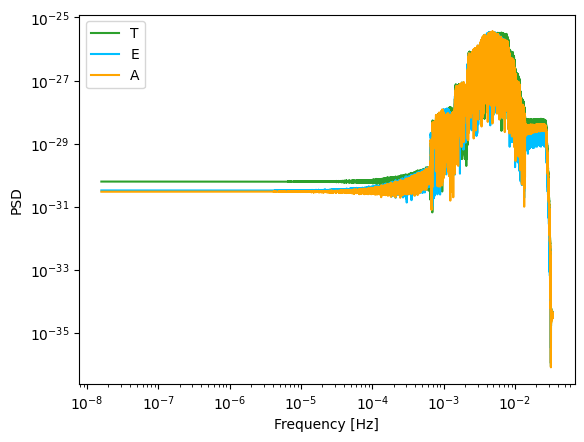

In [87]:
# Preprocess TDI data to get, A, E, T instead of X, Y, Z

L = 2.5E9;

At = np.sqrt(1/2)*(df1['TDI Z']-df1['TDI X'])
Et = np.sqrt(1/6)*(df1['TDI X']- 2*df1['TDI Y']+df1['TDI Z'])
Tt= np.sqrt(1/3)*(df1['TDI X']+df1['TDI Y']+df1['TDI Z'])

AETdata2 = pd.DataFrame(columns = ['Time', 'At','Et','Tt'])
AETdata2['Time'] = df1['Time']
AETdata2['At'] = At
AETdata2['Et'] = Et
AETdata2['Tt'] = Tt
AETdata2

# Create frequency data matrix
aetd_freq = np.zeros(np.shape(tdiArr[:Npts,:]),dtype = np.complex128)
# Take discrete Fourier transform of the noiseless data
aetd_freq[:,1:] = np.array( [ np.fft.fft(tdiArr[:Npts,i]*wind,axis = 0) for i in range(1,4)] ).T
# Compute corresponding frequency vector
aetd_freq[:,0] = freq
# Store the amplitude modulus in data frame (positive frequencies)
aetd_freq_plot = np.zeros(np.shape(td_freq[freq>0,:]),dtype = np.float64) 
aetd_freq_plot[:,0] = freq[freq>0]
# Apply right normalization to get amplitudes 
aetd_freq_plot[:,1:] = np.abs(aetd_freq[freq>0,1:])*2/np.sum(wind)
df_aet = pd.DataFrame(aetd_freq_plot,columns=['freq','TDI A', 'TDI E', 'TDI T'])

plt.figure
plt.loglog(df_aet['freq'], df_aet['TDI T'], label='T', color='tab:green')
plt.loglog(df_aet['freq'], df_aet['TDI E'], label='E', color='deepskyblue')
plt.loglog(df_aet['freq'], df_aet['TDI A'], label='A', color='orange')

plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD")
plt.legend(loc='best')
plt.savefig('AET.pdf')
plt.show()
